In [1]:
## import libraries
import numpy as np
import pandas as pd
import utils
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from math import sqrt
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
from bs4 import BeautifulSoup
import requests
import lxml
import datetime
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from pybaseball import batting_stats_bref
from pybaseball import statcast_batter_expected_stats
from pybaseball import statcast_pitcher_expected_stats
from pybaseball import pitching_stats
from pybaseball import cache
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from scipy.optimize import minimize
import pulp
from pulp import *
import datetime
import random
import pickle
import cProfile
import time
# import logistic regression and accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot

import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
# cache.enable()

optional = ''

In [2]:
# functions



# get today's date formatted as yyyy-mm-dd
def get_todays_date():
  # get the current date
  today = datetime.date.today()
  # format the date as yyyy-mm-dd
  date = today.strftime('%Y-%m-%d')
  # return the date
  return date

# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


def get_starters(date):
  # url for the website
  url = 'https://www.fangraphs.com/livescoreboard.aspx?date=' + date
  # get the website with bs
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  tables = soup.find_all('table', class_='lineup')

  starting = []
  for table in tables:
    row = table.find_all('tr')
    for r in row:
      col = r.find_all('td')
      for c in col:
        a = c.find_all('a')
        if len(a) > 0:
          for i in a:
            name = i.text
            # change names which are not in the correct format
            if name == 'Cedric Mullins II':
              starting.append('Cedric Mullins')
            elif name == 'Mike Siani':
              starting.append('Michael Siani')
            elif name == 'Enrique Hernandez':
              starting.append('Kike Hernandez')
            elif name == 'J.J. Bleday':
              starting.append('JJ Bleday')
            elif name == 'D.J. Stewart':
              starting.append('DJ Stewart')
            else:
              starting.append(name)


  starting_df = pd.DataFrame(starting)
  return starting_df

            
def calculate_batting_fantasy_points(row):
  points = 0
  if row['events']=='single' or row['events'] == 'walk':
    points = points + 3
  elif row['events']=='double':
    points = points + 5
  elif row['events']=='triple':
    points = points + 8
  elif row['events']=='home_run':
    points = points + 10

  points = points + 4 * (row['post_bat_score']- row['bat_score'])

  return points

def calculate_pitching_fantasy_points(row):
  points = 0
  if row['events']=='strikeout':
    points = points + 2.75
  elif row['events']=='double_play' or row['events']=='grounded_into_double_play':
    points = points + 1.5
  elif row['events']=='strikeout_double_play' or row['events']=='strikeout_double_play':
    points = points + 3.5
  elif row['events']=='triple_play':
    points = points + 2.25
  elif row['events']=='single' or row['events'] == 'walk' or row['events'] == 'hit_by_pitch' or row['events'] == 'double' or row['events'] == 'triple' or row['events'] == 'home_run':
    points = points - .6
  else:
    points = points + .75

  points = points - 2 * (row['post_bat_score']- row['bat_score'])
  return points

def total_ball_movement(row):
  # return calculation if is a number else return 0
  x = row['pfx_x']
  z = row['pfx_z']
  if np.isnan(x):
    x = 0
  if np.isnan(z):
    z = 0
  total_movement = sqrt(x**2 + z**2)
  return total_movement

def batter_adjusted_plate_x(row):
  if row['stand'] == 'R':
    return row['plate_x']
  else:
    return -row['plate_x']

# sum batter stats per team for each game
def team_batters_games(df):
  df['team'] = df.apply(team, axis=1)
  team_batters = df.groupby(['game_pk', 'team'])['batter_fp'].sum().reset_index()
  return team_batters
    
# determine team based on inning_topbot
def team(row):
  if row['inning_topbot'] == 'Top':
    return row['away_team']
  else:
    return row['home_team']
  
# sum pitcher stats per team for each game
def team_pitchers_games(df):
  df['team'] = df.apply(team, axis=1)
  team_pitchers = df.groupby(['game_pk', 'team', 'player_name'])['pitcher_fp'].sum().reset_index()
  # get batters faced per pitcher
  batters_faced = df.groupby(['game_pk', 'team', 'player_name'])['batter'].count().reset_index()
  # merge the two dataframes
  team_pitchers = pd.merge(team_pitchers, batters_faced, on=['game_pk', 'team', 'player_name'])
  # for each game, select the pitcher with the most batters faced
  team_pitchers = team_pitchers.sort_values(by=['game_pk', 'batter'], ascending=False).drop_duplicates(subset=['game_pk', 'team'])
  return team_pitchers

# batter fantasy points by game
def batter_fp(df):
  df['batter_fp'] = df.apply(calculate_batting_fantasy_points, axis=1)

  # return points
  batter_game_fp = df.groupby(['game_pk', 'batter'])['batter_fp'].sum().reset_index()
  return batter_game_fp

# get number of plate appearances for each batter
def get_plate_appearances(df):
  plate_appearances = df.groupby(['batter'])['batter'].count().reset_index(name='pa')
  return plate_appearances

# filter the df to only the last x days
def last_x_days(df, x):
  # get the current date
  today = datetime.date.today()
  # get the date x days ago
  x_days_ago = today - datetime.timedelta(days=x)
  # convert to date
  x_days_ago = x_days_ago.strftime('%Y-%m-%d')
  # filter the df to only the last x days
  df = df[df['game_date'] > x_days_ago]
  return df

# fix player names to remove latin characters
def fix_player_names(df, column_name):
  df.loc[:, column_name] = df.loc[:, column_name].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
  # remove suffixes
  df = remove_suffixes(df, column_name)
  return df

# fix players names to move first name to the front and remove commas
def fix_player_names2(df, column_name):
  df[column_name] = df[column_name].str.split(',').str[1] + ' ' + df[column_name].str.split(',').str[0]
  return df

# get the frequency that a player has a stat between two values
def player_stat_frequency(df, player_name, column_name, lower, upper, is_batter=True):
  # filter the df to the selected player depending on if they are a batter or pitcher
  if is_batter:
    df = df[df['batter'] == player_name]
  else:
    df = df[df['player_name'] == player_name]

  # fix for when tyring to divide by zero
  if df.shape[0] == 0:
    return 0
  # find how often column name is between lower and upper
  freq = df[(df[column_name] >= lower) & (df[column_name] <= upper)].shape[0] / df.shape[0]
  return freq

# reformatting for merge
def convert_to_player_name(row):
  name = row['Name']
  # handle case for names with two spaces
  if len(name.split(' ')) > 2:
    return  name.split(' ')[1] + ' ' + name.split(' ')[2] + ', ' + name.split(' ')[0]
  else:
    return name.split(' ')[1] + ', ' + name.split(' ')[0]
    
# get data before date x
def data_before_date(df, y, m, d):
  x = y + "-" + m + "-" + d
  # filter the df to only the last x days
  df = df[df['game_date'] < x]
  return df


def get_batter_game_fp(pregame_info):
    # batter game fp
    batter_game_fp = batter_fp(pregame_info) # replaced batter_recent_info with df

    # get plate appearances for each batter
    plate_appearances = get_plate_appearances(pregame_info) # replaced batter_recent_info with df

    # get batter names
    batter_ids = batter_game_fp['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

    # rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge batter names with batter game fp and plate_appearances
    batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs, on='batter')
    batter_game_fp = pd.merge(batter_game_fp, plate_appearances, on='batter')

    # filter out batters with less than 14 plate appearances
    batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

    # get 25th and 75th percentile outcomes for batter_fp for batters
    batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
    batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
    batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
    batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
    batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)
    return batter_game_fp



def get_pitcher_exp(pregame_info):
    # get all qualified pitchers in 2024
    pitcher_exp = pitching_stats(2024, qual=10)
    pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

    # apply convert_to_player_name to Name column
    pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

    # get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
    pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_speed', 100, 150, is_batter=False), axis=1)
    pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)
    return pitcher_exp


def get_batter_exp(pregame_info):
    # get all of this season's expected batting data so far
    batter_exp = statcast_batter_expected_stats(2024, 20)

    batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
    batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
    # rename first column to batter_name and player_id to batter
    batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
    batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

    # get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
    batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_speed', 100, 150), axis=1)
    batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_angle', 25, 31.25), axis=1)
    return batter_exp


def get_pregame_batting_order(pregame_info):
    # get only the last game for each team
    #pregame_info = pregame_info.groupby(['game_pk', 'team']).apply(lambda x: x.iloc[-1]).reset_index(drop=True)
    # get only the first at bat for each batter per game
    pregame_batting_order = pregame_info.sort_values(by=['game_pk', 'at_bat_number'])
    pregame_batting_order = pregame_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    pregame_batting_order["batting_order"] = pregame_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    pregame_batting_order = pregame_batting_order[pregame_batting_order['batting_order'] <= 9]
    return pregame_batting_order

def trim(col):
    return col.str.strip()

def remove_suffixes(df, col):
    # df[col] = df[col].str.replace(' Jr.', '')
    # df[col] = df[col].str.replace(' Sr.', '')
    # df[col] = df[col].str.replace(' II', '')
    # df[col] = df[col].str.replace(' III', '')
    # df[col] = df[col].str.replace(' IV', '')

    #do the above without chained indexing
    df.loc[:, col] = df.loc[:, col].str.replace(' Jr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' Sr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' III', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' II', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' IV', '')
    return df

def adjust_player_name(row):
  first_name = row['name_first']
  last_name = row['name_last']
  # fix names which are not in the correct format
  if last_name == 'vogelbach':
    return 'dan vogelbach'
  elif last_name == 'siani':
    return 'michael siani'
  elif first_name == 'j. d.':
    return 'j.d. martinez'
  elif row['batter_name'] == 'Michael A. Taylor':
    return 'michael taylor'

  return row['batter_name']

def filter_from_last_game_pks(df, last_game_pks):
  # remove rows in which team and game_pks pairs are not in last_game_pks
  for index, row in df.iterrows():
    if row['game_pk'] not in last_game_pks['game_pk']:
      df = df.drop(index)
    elif row['team'] not in last_game_pks['team']:
      df = df.drop(index)
    elif not(last_game_pks['team'].index_of(row['team']) == last_game_pks['game_pk'].index_of(row['game_pk'])):
      df = df.drop(index)
  return df

In [3]:
# get base df

# Get all Statcast data from 2024
df = statcast(start_dt='2024-03-28', end_dt=get_todays_date())

# Only include events
df = df.dropna(subset=['events', 'pitch_type', 'pfx_x', 'pfx_z', 'plate_x', 'stand', 'game_date', 'game_pk', 'at_bat_number', 'inning_topbot', 'away_team', 'home_team', 'post_bat_score', 'bat_score'])
df = fix_player_names(df, 'player_name')

# get more info
df['pitcher_fp'] = df.apply(lambda row: calculate_pitching_fantasy_points(row), axis=1)
df['batter_fp'] = df.apply(lambda row: calculate_batting_fantasy_points(row), axis=1)
df['total_ball_movement'] = df.apply(lambda row: total_ball_movement(row), axis=1)
df['batter_adjusted_plate_x'] = df.apply(lambda row: batter_adjusted_plate_x(row), axis=1)

# get team batters
team_batters = team_batters_games(df)

# get team pitchers
team_pitchers = team_pitchers_games(df)

# get game_pks and game_dates
game_info = df[['game_pk', 'game_date', 'away_team', 'home_team']].drop_duplicates()

# combine team batters and team pitchers
team_stats = pd.merge(team_batters, team_pitchers, on=['game_pk', 'team'])
# merge with game info
team_stats = pd.merge(team_stats, game_info, on='game_pk')
team_stats.head()

# get 75th percentile outcomes for batter_fp and pitcher_fp for pitchers and teams
team_stats['batter_fp'] = team_stats['batter_fp'].astype(float)
team_stats['pitcher_fp'] = team_stats['pitcher_fp'].astype(float)

# use a dataframe for team-based stats that only uses data from the last 10 days
team_info_df = last_x_days(team_stats, 10)
team_info_df['team_fp_75'] = team_info_df.groupby('team')['batter_fp'].transform(lambda x: x.quantile(.75))
team_info_df['opp_pitcher_fp_75'] = team_info_df.groupby('team')['pitcher_fp'].transform(lambda x: x.quantile(.75))
team_info_df['team_fp_75'] = team_info_df['team_fp_75'].fillna(0)
team_info_df['opp_pitcher_fp_75'] = team_info_df['opp_pitcher_fp_75'].fillna(0)

# pitchers can have full season stats
team_stats['pitcher_fp_75'] = team_stats.groupby('player_name')['pitcher_fp'].transform(lambda x: x.quantile(.75))
team_stats['opp_team_fp_75'] = team_stats.groupby('player_name')['batter_fp'].transform(lambda x: x.quantile(.75))
team_stats['pitcher_fp_75'] = team_stats['pitcher_fp_75'].fillna(0)
team_stats['opp_team_fp_75'] = team_stats['opp_team_fp_75'].fillna(0)

# separate teams and pitchers 75th percentiles, and drop duplicates
pitcher_outliers = team_stats[['player_name', 'pitcher_fp_75', 'opp_team_fp_75']].drop_duplicates()
pitcher_outliers = fix_player_names(pitcher_outliers, 'player_name')
team_outliers = team_info_df[['team', 'team_fp_75', 'opp_pitcher_fp_75']].drop_duplicates()

# change team from AZ to ARI and WSH to WAS
team_outliers['team'] = team_outliers['team'].replace({'AZ': 'ARI', 'WSH': 'WAS'})

#pitcher_outliers.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_outliers.csv', index=False)
team_outliers.to_csv('C:\\Users\\jorda\\Downloads\\team_outliers.csv', index=False)

# use last_x_days to filter df for recency
# batter_recent_info = last_x_days(df, 10)

# finding recency bias to be problematic, so we will use all data

# batter game fp
batter_game_fp = batter_fp(df) # replaced batter_recent_info with df

# get plate appearances for each batter
plate_appearances = get_plate_appearances(df) # replaced batter_recent_info with df

# get batter names
batter_ids = batter_game_fp['batter'].unique()
batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

# rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

# merge batter names with batter game fp and plate_appearances
batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs, on='batter')
batter_game_fp = pd.merge(batter_game_fp, plate_appearances, on='batter')

# filter out batters with less than 14 plate appearances
batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

# get 25th and 75th percentile outcomes for batter_fp for batters
batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)

# select only batter_name and batter_fp_75 and drop duplicates
batter_outliers = batter_game_fp[['batter_name', 'batter_fp_25', 'batter_fp_75', 'batter']].drop_duplicates()
# batter_outliers.to_csv('C:\\Users\\jorda\\Downloads\\batter_outliers.csv', index=False)



# get data for all qualified pitchers in 2024
pitcher_exp = pitching_stats(2024, qual=10)
pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

# apply convert_to_player_name to Name column
pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

# get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_speed', 100, 109, is_batter=False), axis=1)
pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)


# merge with pitcher_outliers
pitcher_exp = pd.merge(pitcher_exp, pitcher_outliers, on='player_name')
pitcher_exp.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_exp.csv', index=False)


# get all of this season's expected batting data so far
batter_exp = statcast_batter_expected_stats(2024)
batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
# rename first column to batter_name and player_id to batter
batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

# get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_speed', 100, 150), axis=1)
batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_angle', 25, 31.25), axis=1)
# merge with batter_outliers

batter_exp = pd.merge(batter_exp, batter_outliers, on='batter')
batter_exp.to_csv('C:\\Users\\jorda\\Downloads\\batter_exp.csv', index=False)

# summarize df
batter_summary = batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()

# get only the first at bat for each batter per game
batting_order = df.sort_values(by=['game_pk', 'at_bat_number'])
batting_order = batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
batting_order["batting_order"] = batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
batting_order = batting_order[batting_order['batting_order'] <= 9]

pitcher_exp["player_name"] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

model_data = pd.merge(batter_summary, batting_order, on=['game_pk', 'batter'])
model_data = pd.merge(model_data, batter_exp, on='batter')
model_data = pd.merge(model_data, pitcher_exp, on='player_name')

pitcher_summary = df.groupby(['game_pk', 'player_name'])['pitcher_fp'].sum().reset_index()
model_data = pd.merge(model_data, pitcher_summary, on=['game_pk', 'player_name'])

This is a large query, it may take a moment to complete


100%|██████████| 91/91 [00:12<00:00,  7.49it/s]


In [4]:
# get mean pitch coordinates
# mean_pitch_coordinates = df.groupby(['pitcher', 'player_name'])[['plate_x', 'plate_z', 'batter_adjusted_plate_x']].mean()
# mean_pitch_coordinates.rename(columns={'plate_x':'mean_pitcher_plate_x', 'plate_z':'mean_pitcher_plate_z', 'batter_adjusted_plate_x':'mean_pitcher_batter_adjusted_plate_x'}, inplace=True)
# mean_pitch_coordinates.to_csv("C:\\Users\\jorda\\Downloads\\pitch_coordinates.csv")
# mean_pitch_coordinates.head()
# df = statcast(start_dt='2024-03-28', end_dt=get_todays_date())

# # Only include events
# df = df.dropna(subset=['events', 'pitch_type', 'pfx_x', 'pfx_z', 'plate_x', 'stand', 'game_date', 'game_pk', 'at_bat_number', 'inning_topbot', 'away_team', 'home_team', 'post_bat_score', 'bat_score'])
# df = fix_player_names(df, 'player_name')


Analysis of Past Slates

In [5]:
# get draftkings salaries based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLBMMDDYYYY.csv"
def get_pregame_info(df, year, month, day):
    pregame_info = data_before_date(df, year, month, day)

    pregame_batter_game_fp = get_batter_game_fp(pregame_info)
    pregame_pitcher_exp = get_pitcher_exp(pregame_info)
    pregame_batter_exp = get_batter_exp(pregame_info)

    # summarize df
    pregame_batter_summary = pregame_batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()


    pregame_batting_order = get_pregame_batting_order(pregame_info)

    # get batter, game_pk, and batting order from pregame_batting_order
    pregame_batting_order = get_pregame_batting_order(pregame_info)
    pregame_batting_order = pregame_batting_order[['batter', 'game_pk', 'batting_order', 'player_name']]

    # merge all pregame data
    pregame_data = pd.merge(pregame_batter_summary, pregame_batting_order, on=['game_pk', 'batter'])
    pregame_data = pd.merge(pregame_data, pregame_batter_exp, on='batter')

    pregame_data = pd.merge(pregame_data, pregame_pitcher_exp, on='player_name')

    # add pitcher_fp to pregame_data
    pregame_data = pd.merge(pregame_data, pitcher_summary, on=['game_pk', 'player_name'])

    pregame_batter_game_fp_mean = pregame_data[['batter_name', 'batting_order', 'batter_fp']]
    pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.groupby('batter_name').mean().reset_index()
    pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.rename(columns={'batting_order': 'avg_batting_order', 'batter_fp': 'avg_batter_fp'})
    # merge the two dataframes
    pregame_data = pd.merge(pregame_data, pregame_batter_game_fp_mean, on='batter_name')
    # add a column for the change in batting order
    pregame_data['batting_order_change'] = pregame_data['avg_batting_order'] - pregame_data['batting_order']

    return pregame_data

def get_dk_salaries(year, month, day, optional=""):
    string = "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\DKSalariesMLB" + month + day + year + optional + ".csv"
    print(string)
    salaries = pd.read_csv(string)
    return salaries

# get contest standings based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandingsMMDDYYYY.csv"
def get_contest_standings(year, month, day):
    string = "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\MLBContestStandings" + month + day + year + ".csv"
    print(string)
    contest_data = pd.read_csv(string)
    return contest_data

def get_contest_results(contest_data):
    contest_player_results = contest_data[['Player', '%Drafted', 'FPTS']]
    # drop nas
    contest_player_results = contest_player_results.dropna()
    # convert %Drafted to a float
    contest_player_results['%Drafted'] = contest_player_results['%Drafted'].str.replace('%', '').astype(float)
    # convert FPTS to a float
    contest_player_results['FPTS'] = contest_player_results['FPTS'].astype(float)
    # fix player names
    contest_player_results = fix_player_names(contest_player_results, 'Player')
    # remove suffixes
    contest_player_results = remove_suffixes(contest_player_results, 'Player')
    return contest_player_results

def get_leaderboard(contest_data):
    leaderboard = contest_data[['Rank', 'Points', 'Lineup']]
    leaderboard = leaderboard.dropna()
    # convert Points to a float
    leaderboard['Points'] = leaderboard['Points'].astype(float)
    return leaderboard

# get files in folder "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\" and return their names
def get_files():
    files = []
    for file in os.listdir("C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\"):
        if file.endswith(".csv"):
            files.append(file)
    return files

In [6]:

def compile_data_from_date(df, year, month, day):
    # merge dk salaries with pregame_data by batter_name
    salaries = get_dk_salaries(year, month, day, "")

    # select Name, Roster Position, Salary, and TeamAbbrev from salaries
    salaries = salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # only keep Name and Salary for pitchers
    pitcher_salaries = pitcher_salaries[['Name', 'Salary', 'TeamAbbrev']]
    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name', 'TeamAbbrev':'pitcher_team'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})

    this_day_statcast = statcast(start_dt=year + '-' + month + '-' + day, end_dt=year + '-' + month + '-' + day)
    # set 'team' as home_team if inning_topbot is 'Bot', and away_team if 'Top'
    this_day_statcast['team'] = this_day_statcast.apply(team, axis=1)
    # get only the first at bat for each batter per game
    this_day_batting_order = this_day_statcast.sort_values(by=['game_pk', 'at_bat_number'])
    this_day_batting_order = this_day_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    this_day_batting_order["batting_order"] = this_day_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    this_day_batting_order = this_day_batting_order[this_day_batting_order['batting_order'] <= 9]

    # get batter_name for this_day_batting_order
    batter_ids = this_day_batting_order['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge this_day_batting_order with batter_name_id_pairs
    this_day_batting_order = pd.merge(this_day_batting_order, batter_name_id_pairs, on='batter')

    # get pitcher_name for this_day_batting_order based on player_name
    this_day_batting_order = fix_player_names(this_day_batting_order, 'player_name')
    this_day_batting_order= fix_player_names2(this_day_batting_order, 'player_name')
    # rename player_name to Name
    this_day_batting_order = this_day_batting_order.rename(columns={'player_name': 'Name'})
    # merge with pitcher_salaries
    bo_with_salaries = pd.merge(this_day_batting_order, hitter_salaries)
    # only keep Name, team, batting_order, batter_name, Roster Position, Salary
    bo_with_salaries = bo_with_salaries[['Name', 'team', 'batting_order', 'batter_name', 'Roster Position', 'Salary']]
    bo_with_salaries = bo_with_salaries.rename(columns={'Salary': 'batter_salary'})
    bo_with_salaries = bo_with_salaries.rename(columns={'Name': 'pitcher_name'})
    # trim pitcher_name in bo_with_salaries
    bo_with_salaries['pitcher_name'] = trim(bo_with_salaries['pitcher_name'])
    # merge with pitcher_salaries
    new_merge = pd.merge(bo_with_salaries, pitcher_salaries, on='pitcher_name')


    # use historic data to determine hitter and pitcher quality, with the goal of predicting batter_fp and pitcher_fp
    pregame_data = get_pregame_info(df, year, month, day)

    # get pitcher names, plus WHIP, Pitching+
    pitcher_names = pregame_data[['player_name', 'WHIP', 'Pitching+', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # rename player_name to pitcher_name
    pitcher_names = pitcher_names.rename(columns={'player_name': 'pitcher_name'})
    # fix names
    pitcher_names = fix_player_names(pitcher_names, 'pitcher_name')
    pitcher_names = fix_player_names2(pitcher_names, 'pitcher_name')
    # trim names
    pitcher_names['pitcher_name'] = trim(pitcher_names['pitcher_name'])
    # drop duplicates
    pitcher_names = pitcher_names.drop_duplicates()
    # get batter names, plus 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'avg_batting_order', 'avg_batter_fp'
    batter_names = pregame_data[['batter_name', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'avg_batting_order', 'avg_batter_fp']]
    # trim names
    batter_names['batter_name'] = trim(batter_names['batter_name'])
    # drop duplicates
    batter_names = batter_names.drop_duplicates()

    # merge with new_merge by names to set up predictions
    all_data = pd.merge(new_merge, pitcher_names, on='pitcher_name')
    all_data = pd.merge(all_data, batter_names, on='batter_name')

    # add batting_order_change to df
    all_data['batting_order_change'] = all_data['avg_batting_order'] - all_data['batting_order']

    

    # establish a model for each batter depending on the quality of pitcher they are facing
    batter_model = LinearRegression()
    # select only the relevant columns
    batter_model_data = pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']]
    # set target as batter_fp
    target = pregame_data['batter_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(batter_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    batter_model.fit(X_train, y_train)
    # predict the model
    # calculate r2 and rmse
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Batter Model R2: ', r2)
    # print('Batter Model RMSE: ', rmse)

    # predict batter_fp and pitcher_fp for all_data
    all_data['batter_fp_pred'] = batter_model.predict(all_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])

    # get only one row for each pitcher_name by taking the mean of relevant columns
    pitcher_data = all_data[['pitcher_name', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    pitcher_data = pitcher_data.groupby('pitcher_name').mean().reset_index()

    # establish a model for each pitcher depending on the quality of batters they are facing
    # establish a model for each pitcher depending on the quality of the batters they are facing
    pitcher_model = LinearRegression()
    # select only the relevant columns
    pregame_pitcher_data = pregame_data[['player_name', 'game_pk', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp']]
    # group by Name and game_pk and use mean for each column
    pregame_pitcher_data = pregame_pitcher_data.groupby(['player_name', 'game_pk']).mean().reset_index()
    # select only the relevant columns
    pitcher_model_data = pregame_pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # set target as pitcher_fp
    target = pregame_pitcher_data['pitcher_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(pitcher_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    pitcher_model.fit(X_train, y_train)
    # predict the model
    # calculate r2 and rmse
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Pitcher Model R2: ', r2)
    # print('Pitcher Model RMSE: ', rmse)

    # need ['teams_in_game_pk', 'is_of', 'team_batter_fp_pred']
    # get teams_in_game_pk
    # teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
    # all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size
    teams_in_game_pk = all_data['team'].unique()
    all_data['teams_in_game_pk'] = teams_in_game_pk.size
    # get is_of
    all_data['is_of'] = all_data['Roster Position'].apply(lambda x: 1 if x == 'OF' else 0)
    # get team_batter_fp_pred
    team_batter_fp_pred = all_data.groupby('team')['batter_fp_pred'].mean().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data = pd.merge(all_data, team_batter_fp_pred, on='team')

    # predict pitcher_fp for pitcher_data
    pitcher_data['pitcher_fp_pred'] = pitcher_model.predict(pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']])

    # select only pitcher_name and pitcher_fp_pred, then merge with all_data
    pitcher_data = pitcher_data[['pitcher_name', 'pitcher_fp_pred']]
    all_data = pd.merge(all_data, pitcher_data, on='pitcher_name')

    # use leaderboard and results to determine the success of each player
    contest_data = get_contest_standings(year, month, day)
    contest_player_results = get_contest_results(contest_data)
    leaderboard = get_leaderboard(contest_data)

    # Establish payoffs for each player based on their performance as well as their appearance in the leaderboard's top 100
    # get the top 20 lineups
    top_20 = leaderboard.head(20)
    # get all players in the all_data dataframe
    all_players = all_data['batter_name'].unique()
    # get pitchers as well
    pitchers = all_data['pitcher_name'].unique()
    # combine those vectors
    all_players = np.concatenate((all_players, pitchers))

    # enumerate payoffs for placements in the top 20
    payoffs = [50000, 20000, 8000, 5000, 4000, 3000, 2000, 2000, 1000, 1000, 700, 700, 500, 500, 500, 500, 500, 400, 400, 400]

    # create a dictionary for player payoffs
    player_payoffs = {}

    # for each lineup in top_20, look for each player in all_players and increase their payoff by the corresponding value in payoffs if found
    for index, row in top_20.iterrows():
        lineup = row['Lineup']
        for player in all_players:
            if player in lineup:
                if player in player_payoffs:
                    player_payoffs[player] += payoffs[index]
                else:
                    player_payoffs[player] = payoffs[index]

    # for each player in all_players, if they are not in player_payoffs, set their payoff to 0
    for player in all_players:
        if player not in player_payoffs:
            player_payoffs[player] = 0

    # add player payoffs to all_data
    all_data['payoff'] = all_data['batter_name'].map(player_payoffs)

    # add pitcher payoffs to all_data
    all_data['pitcher_payoff'] = all_data['pitcher_name'].map(player_payoffs)


    # add contest results to all_data
    all_data_with_results = pd.merge(all_data, contest_player_results, left_on='batter_name', right_on='Player', how='left')
    # rename %drafted to batter_drafted and FPTS to batter_fpts
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'batter_drafted', 'FPTS': 'batter_fpts'})
    # drop Player column
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # do the same for pitchers
    all_data_with_results = pd.merge(all_data_with_results, contest_player_results, left_on='pitcher_name', right_on='Player', how='left')
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'pitcher_drafted', 'FPTS': 'pitcher_fpts'})
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # divide payoff and pitcher_payoff by (leaderboard_size * percent_drafted) to get payoff per usage
    leaderboard_size = leaderboard.shape[0]
    all_data_with_results['payoff'] = all_data_with_results['payoff'] / (leaderboard_size * all_data_with_results['batter_drafted']/100)
    all_data_with_results['pitcher_payoff'] = all_data_with_results['pitcher_payoff'] / (leaderboard_size * all_data_with_results['pitcher_drafted']/100)

    # get mean drafted % by team for pitchers
    team_pitcher_drafted = all_data_with_results.groupby('team')['pitcher_drafted'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted': 'opp_pitcher_drafted_mean'})
    all_data_with_results = pd.merge(all_data_with_results, team_pitcher_drafted, on='team')

    # get mean drafted % by pitcher_team for batters
    team_batter_drafted = all_data_with_results.groupby('pitcher_team')['batter_drafted'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted': 'opp_batter_drafted_mean'})
    all_data_with_results = pd.merge(all_data_with_results, team_batter_drafted, on='pitcher_team')

    # add a column for team_batter_fp_pred
    team_batter_fp_pred = all_data_with_results.groupby('team')['batter_fp_pred'].sum().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data_with_results = pd.merge(all_data_with_results, team_batter_fp_pred, on='team')
    
    # X = all_data_with_results[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred']]
    # y = all_data_with_results['batter_drafted']
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # # build a linear regression model to predict the ownership of each batter
    # model_batter_drafted = LinearRegression()
    # model_batter_drafted.fit(X_train, y_train)
    # y_pred = model_batter_drafted.predict(X_test)
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Ownership Model R2: ', r2)
    # print('Ownership Model RMSE: ', rmse)

    return all_data_with_results


def get_opposing_team(team, game_info):
    # if game info includes Postponed or game_info dtype is float return None
    if game_info == 'Postponed':
        return None
    if type(game_info) == float:
        return None
    # get the opposing team from the game_info
    matchup = game_info.split(' ')[0]
    teams = matchup.split('@')
    if teams[0] == team:
        return teams[1]
    else:
        return teams[0]


In [7]:
def get_all_data_from_draftkings():
    # run compile_data_from_date for all dates and combine the results into a single dataframe
    all_data = pd.DataFrame()
    files = get_files()

    for file in files:
        # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
        if 'MLBContestStandings' in file:
            date = file[-12:-4]
            m = str(date[0:2])
            d = str(date[2:4])
            y = str(date[4:8])
            
            all_data = pd.concat([all_data, compile_data_from_date(df, y, m, d)])

    # drop NaNs
    all_data = all_data.dropna()
    # add a column with value 1 if Roster Position contains OF or /
    all_data['is_of'] = all_data['Roster Position'].str.contains('OF|/').astype(int)

    # save all_data to csv in case of loss
    all_data.to_csv('C:\\Users\\jorda\\Downloads\\all_data.csv', index=False)


Below, use to get all old contest data; should not be run more than once per day as all data can be read from CSV

In [8]:
# uncomment the line below to get all data from DraftKings
# get_all_data_from_draftkings()

In [9]:
def get_all_data_plus_team_batter_fp_pred():
    # read from all_data to save time
    all_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_data.csv')

    # get team_batter_fp_pred
    team_batter_fp_pred = all_data.groupby(['team', 'pitcher_name'])['batter_fp_pred'].mean().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data = pd.merge(all_data, team_batter_fp_pred, on=['team', 'pitcher_name'])

    # multiply by 9 for team_batter_fp_pred
    all_data['team_batter_fp_pred'] = all_data['team_batter_fp_pred'] * 9
    return all_data

all_data = get_all_data_plus_team_batter_fp_pred()


Batter Drafted % Linear Regression model

In [10]:
# model batter_drafted from all_data
X = all_data[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of', 'team_batter_fp_pred']]
y = all_data['batter_drafted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# build a linear regression model to predict the ownership of each batter
model_batter_drafted = LinearRegression()
model_batter_drafted.fit(X_train, y_train)
y_pred = model_batter_drafted.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Ownership Model R2: ', r2)
print('Ownership Model RMSE: ', rmse)


Ownership Model R2:  0.44289138520045235
Ownership Model RMSE:  4.040197290698783


In [11]:
def add_batter_ownership(all_data=all_data, model_batter_drafted=model_batter_drafted, X=X):
    # create a copy of all_data and add the predicted ownership to it
    all_data_with_ownership = all_data.copy()
    all_data_with_ownership['batter_drafted_pred'] = model_batter_drafted.predict(X)
    all_data_with_ownership['batter_drafted_pred'] = all_data_with_ownership['batter_drafted_pred']
    all_data_with_ownership.head()
    return all_data_with_ownership

all_data_with_ownership = add_batter_ownership()

In [12]:
# reduce df to pitcher name, batter_salary, pitcher_salary, WHIP, Pitching+, team, pitcher_fp_pred, pitcher_drafted, team_batter_fp_pred, and teams_in_game_pk; get sum of batter_salary and mean of everything else
pitcher_data = all_data_with_ownership[['pitcher_name', 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'team', 'pitcher_fp_pred', 'pitcher_drafted', 'team_batter_fp_pred', 'teams_in_game_pk']]
pitcher_data = pitcher_data.groupby(['pitcher_name', 'pitcher_drafted']).agg({'batter_salary': 'sum', 'pitcher_salary': 'mean', 'WHIP': 'mean', 'Pitching+': 'mean', 'pitcher_fp_pred': 'mean', 'team_batter_fp_pred': 'mean', 'teams_in_game_pk': 'mean'}).reset_index()
# merge this with unique pitcher_name and pitcher_drafted
pitcher_data.head()

,pitcher_name,pitcher_drafted,batter_salary,pitcher_salary,WHIP,Pitching+,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk
0,Aaron Civale,0.81,34500,7800.0,1.39,101.0,9.323685,75.450177,20.0
1,Aaron Civale,1.95,33300,7200.0,1.39,101.0,10.920535,72.342391,26.0
2,Adam Mazur,1.29,22300,7700.0,2.05,95.0,1.121708,90.314884,14.0
3,Albert Suarez,1.56,33800,7400.0,1.20,95.0,10.738687,71.081774,20.0
4,Albert Suarez,2.13,17400,7600.0,1.20,95.0,15.968549,52.959284,26.0


In [13]:
# linear regression model to predict pitcher_drafted
# rename batter_salary to team_batter_salary
pitcher_data = pitcher_data.rename(columns={'batter_salary': 'team_batter_salary'})
X = pitcher_data[['team_batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']]
y = pitcher_data['pitcher_drafted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model_pitcher_drafted = LinearRegression()
model_pitcher_drafted.fit(X_train, y_train)
y_pred = model_pitcher_drafted.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Pitcher Ownership Model R2: ', r2)
print('Pitcher Ownership Model RMSE: ', rmse)


Pitcher Ownership Model R2:  0.4411808632988785
Pitcher Ownership Model RMSE:  10.046498950239984


In [14]:

# get team_batter_salary for all_data_with_ownership
team_batter_salary = all_data_with_ownership.groupby('team')['batter_salary'].sum().reset_index()
team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
all_data_with_ownership = pd.merge(all_data_with_ownership, team_batter_salary, on='team')

# add pitcher_drafted_pred to all_data_with_ownership
all_data_with_ownership['pitcher_drafted_pred'] = model_pitcher_drafted.predict(all_data_with_ownership[['team_batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']])


In [15]:

batter_model_features = ['avg_batter_fp', 'teams_in_game_pk', 'batting_order',  'est_woba',  'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq','team_batter_fp_pred']
# create a tensorflow model to predict payoff for each player
X = all_data_with_ownership[batter_model_features]
y = all_data_with_ownership['payoff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


model_payoff = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model_payoff.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

history = model_payoff.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=100
)

y_pred = model_payoff.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Payoff Model R2: ', r2)
print('Payoff Model RMSE: ', rmse)




Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1573.0647 - val_loss: 5261.7539
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1974.3619 - val_loss: 5261.9844
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1392.9271 - val_loss: 5285.9458
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1613.6847 - val_loss: 5266.9185
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1067.6407 - val_loss: 5265.6313
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1183.7844 - val_loss: 5267.3159
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1338.1003 - val_loss: 5266.5039
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1843.8721 - val_loss: 5267.5156
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1244.0602 - val_loss: 5270.2710
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1110.0975 - val_loss: 5264.2783
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1899.7961 - val_loss: 5267.9

In [16]:
# build a model for pitcher payoffs
just_pitcher_payoff_data = all_data_with_ownership[['pitcher_fp_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'opp_batter_drafted_mean', 'team_batter_fp_pred', 'team_batter_salary', 'WHIP', 'pitcher_payoff', 'teams_in_game_pk', 'opp_pitcher_drafted_mean']]
just_pitcher_payoff_data = just_pitcher_payoff_data.drop_duplicates()
X = just_pitcher_payoff_data[['pitcher_fp_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'opp_batter_drafted_mean', 'team_batter_fp_pred', 'team_batter_salary', 'WHIP', 'teams_in_game_pk', 'opp_pitcher_drafted_mean']]
y = just_pitcher_payoff_data['pitcher_payoff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# build a linear regression model to predict the payoff of each pitcher
model_pitcher_payoff = LinearRegression()
model_pitcher_payoff.fit(X_train, y_train)
y_pred = model_pitcher_payoff.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Pitcher Payoff Model R2: ', r2)
print('Pitcher Payoff Model RMSE: ', rmse)


Pitcher Payoff Model R2:  0.05120520314730814
Pitcher Payoff Model RMSE:  12.844030860524551


In [17]:
# show which players correspond to the highest predicted payoffs
all_data_with_payoff_pred  = all_data_with_ownership.copy()
all_data_with_payoff_pred['payoff_pred'] = model_payoff.predict(all_data_with_payoff_pred[batter_model_features])
all_data_with_payoff_pred = all_data_with_payoff_pred.sort_values(by='payoff_pred', ascending=False)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


In [18]:

# get avg_batter_fp, avg_batting_order, and for pregame_data
pregame_data = get_pregame_info(df, year, month, day)

In [124]:
todays_salaries = get_dk_salaries(year, month, day, optional)

# select Name, Roster Position, Salary, and TeamAbbrev from salaries
salaries = todays_salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]
# fixnames
salaries = fix_player_names(salaries, 'Name')

# remove Jr., Sr., II, and III from names
salaries = remove_suffixes(salaries, 'Name')

# get all players who are not Roster Position P
hitter_salaries = salaries[salaries['Roster Position'] != 'P']

# get all players who are Roster Position P
pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

# rename salary to pitcher_salary
pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})

# rename hitter_salaries Name to batter_name
hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})
hitter_salaries.reset_index(drop=True, inplace=True)

# get batting orders from get_starters, or by using the last game_pk for the team in df
starters = get_starters(year+'-'+month+'-'+day)

# rename starters to batter_name
starters = starters.rename(columns={0: 'batter_name'})

# trim hitter_salaries
hitter_salaries['batter_name'] = trim(hitter_salaries['batter_name'])
# trim starters
starters['batter_name'] = trim(starters['batter_name'])

# remove Jr., Sr., II, and III from names
starters = remove_suffixes(starters, 'batter_name')

starting_hitters_salaries = hitter_salaries[hitter_salaries['batter_name'].isin(starters['batter_name'])]
starting_hitters_bo = starters[starters['batter_name'].isin(hitter_salaries['batter_name'])]
starting_hitters_bo = starting_hitters_bo.reset_index(drop=True)

# add a row to starting_hitters_bo that equals index mod 9 + 1
starting_hitters_bo['batting_order'] = (starting_hitters_bo.index % 9) + 1

# merge starting_hitters_bo with starting_hitters_salaries
starting_hitters = pd.merge(starting_hitters_bo, starting_hitters_salaries, on='batter_name')


# get hitters for teams which are in hitter_salaries but not in starting_hitters
missing_hitters = hitter_salaries[~hitter_salaries['TeamAbbrev'].isin(starting_hitters['TeamAbbrev'])]['TeamAbbrev'].unique()
missing_hitters

# if there are missing hitters
if len(missing_hitters) > 0:
    # first at bats for each team in their last recorded game:
    last_game_pks = df.groupby('team').first().reset_index()[['team', 'game_pk']]
    last_game_pks['tgp'] = last_game_pks['team'] + last_game_pks['game_pk'].astype(str)

    # remove teams not in missing_hitters
    last_game_pks = last_game_pks[last_game_pks['team'].isin(missing_hitters)]

    # get df rows where game_pk is in last_game_pks
    missing_hitters_df = df[df['game_pk'].isin(last_game_pks['game_pk'])]
    missing_hitters_df.loc[:,'tgp'] = missing_hitters_df.loc[:,'team'] + missing_hitters_df.loc[:,'game_pk'].astype(str)

    # remove teams not in missing_hitters
    missing_hitters_df = missing_hitters_df[missing_hitters_df['tgp'].isin(last_game_pks['tgp'])]
    # get the first at bat for each batter in missing_hitters_df
    missing_hitters_df = missing_hitters_df.sort_values(by=['game_pk','at_bat_number'])
    missing_hitters_df["batting_order"] = missing_hitters_df.groupby(['team'])['at_bat_number'].rank()
    missing_hitters_df = missing_hitters_df[missing_hitters_df['batting_order'] <= 9]

    # drop tgp
    missing_hitters_df = missing_hitters_df.drop(columns='tgp')


    # get batter_name for missing_hitters_df
    batter_ids = missing_hitters_df['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # treat batter_name_id_pairs['batter_name'] the same as starters above
    batter_name_id_pairs = fix_player_names(batter_name_id_pairs, 'batter_name')
    batter_name_id_pairs = remove_suffixes(batter_name_id_pairs, 'batter_name')
    batter_name_id_pairs['batter_name'] = trim(batter_name_id_pairs['batter_name'])

    # apply formula adjust_player_name to batter_name_id_pairs by row, which will fix the names which are not formatted the same as the other dataframes
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs.apply(lambda row: adjust_player_name(row), axis=1)


    # merge batter_name_id_pairs and missing_hitters_df on batter
    missing_hitters_salaries = pd.merge(missing_hitters_df, batter_name_id_pairs, on='batter')

    # get name and batting order
    missing_hitters_salaries = missing_hitters_salaries[['batter_name', 'batting_order']]

    # convert batter_name to lowercase for merge
    missing_hitters_salaries['batter_name_lower'] = missing_hitters_salaries['batter_name'].str.lower()
    # drop batter_name
    missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name')
    hitter_salaries['batter_name_lower'] = hitter_salaries['batter_name'].str.lower()

    # merge missing_hitters_salaries with hitter_salaries on batter_name
    missing_hitters_salaries = pd.merge(missing_hitters_salaries, hitter_salaries, on='batter_name_lower').drop_duplicates()

    #remove batter_name_lower
    missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name_lower')

    # concat with starting_hitters
    starting_hitters = pd.concat([starting_hitters, missing_hitters_salaries])



# get all players who are Roster Position P
pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

# rename salary to pitcher_salary
pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})



# get opposing team from Game Info as team that is not TeamAbbrev
pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)

# keep pitcher_name, pitcher_salary, opp_team
pitcher_salaries = pitcher_salaries[['pitcher_name', 'pitcher_salary', 'opp_team']]

# rename opp_team to team
pitcher_salaries = pitcher_salaries.rename(columns={'opp_team': 'TeamAbbrev'})

# only keep pitchers who are in starters['batter_name']
pitcher_salaries = pitcher_salaries[pitcher_salaries['pitcher_name'].isin(starters['batter_name'])]

# merge starting_hitters with pitcher_salaries on TeamAbbrev
all_players = pd.merge(starting_hitters, pitcher_salaries, on='TeamAbbrev')


# get only the last instance of pregame_data for each batter_name and pitcher_name
batter_data = pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].drop_duplicates(subset='batter_name', keep='last')
pitcher_data = pregame_data[['player_name', 'Pitching+', 'WHIP', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']].drop_duplicates(subset='player_name', keep='last')




# trim names
batter_data = fix_player_names(batter_data, 'batter_name')
batter_data['batter_name'] = trim(batter_data['batter_name'])
pitcher_data = fix_player_names(pitcher_data, 'player_name')
pitcher_data = fix_player_names2(pitcher_data, 'player_name')
pitcher_data['player_name'] = trim(pitcher_data['player_name'])

# remove Jr., Sr., II, and III from names
batter_data = remove_suffixes(batter_data, 'batter_name')
pitcher_data = remove_suffixes(pitcher_data, 'player_name')
# for pitchers who are not in pregame_data, use the range defined below for the columns times their salary/10000 to get a prediction for their stats
pitcher_salaries_not_in_pregame_data = pitcher_salaries[~pitcher_salaries['pitcher_name'].isin(pitcher_data['player_name'])][['pitcher_name', 'pitcher_salary']]
pitcher_salaries_not_in_pregame_data = pitcher_salaries_not_in_pregame_data.rename(columns={'pitcher_name': 'player_name'})
# Pitching+ should be between 90 and 105
# WHIP should be between 1.5 and 1.0 (lower is better)
# hr_friendly_launch_speed_pitcher should be between .07 and .15
# hr_friendly_launch_angle_pitcher should be between .2 and .4
pitcher_salaries_not_in_pregame_data['Pitching+'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 15 + 90
pitcher_salaries_not_in_pregame_data['WHIP'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * -0.05 + 1.5
pitcher_salaries_not_in_pregame_data['hr_friendly_launch_speed_pitcher'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 0.0008 + 0.07
pitcher_salaries_not_in_pregame_data['hr_friendly_launch_angle_pitcher'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 0.0002 + 0.2

# drop pitcher_salary
pitcher_salaries_not_in_pregame_data = pitcher_salaries_not_in_pregame_data.drop(columns='pitcher_salary')

# add pitcher_salaries_not_in_pregame_data to pitcher_data
pitcher_data = pd.concat([pitcher_data, pitcher_salaries_not_in_pregame_data])

# rename player_name to pitcher_name
pitcher_data = pitcher_data.rename(columns={'player_name': 'pitcher_name'})

# merge with all_players
all_players_plus_data = pd.merge(all_players, batter_data, on='batter_name')
all_players_plus_data = pd.merge(all_players_plus_data, pitcher_data, on='pitcher_name')

# add a column for the change in batting order
all_players_plus_data['batting_order_change'] = all_players_plus_data['avg_batting_order'] - all_players_plus_data['batting_order']


# establish a model for each batter depending on the quality of pitcher they are facing
batter_model = LinearRegression()
# select only the relevant columns
batter_model_data = pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']]
# set target as batter_fp
target = pregame_data['batter_fp']
# split the data
X_train, X_test, y_train, y_test = train_test_split(batter_model_data, target, test_size=0.2, random_state=0)
# fit the model
batter_model.fit(X_train, y_train)
# predict the model
# y_pred = batter_model.predict(X_test)
# calculate r2 and rmse
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))
# print('Batter Model R2: ', r2)
# print('Batter Model RMSE: ', rmse)

# predict batter_fp and pitcher_fp for all_data
pregame_data['batter_fp_pred'] = batter_model.predict(pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])

# get only one row for each pitcher_name by taking the mean of relevant columns
opp_bats_pitcher_data = all_players_plus_data[['pitcher_name','est_woba', 'est_slg', 'est_ba']]
pitcher_data = pd.merge(pitcher_data, opp_bats_pitcher_data, on='pitcher_name')
pitcher_data = pitcher_data.groupby('pitcher_name').mean().reset_index()

# establish a model for each pitcher depending on the quality of batters they are facing
# establish a model for each pitcher depending on the quality of the batters they are facing
pitcher_model = LinearRegression()
# select only the relevant columns
pregame_pitcher_data = pregame_data[['player_name', 'game_pk', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp']]
# group by Name and game_pk and use mean for each column
pregame_pitcher_data = pregame_pitcher_data.groupby(['player_name', 'game_pk']).mean().reset_index()
# select only the relevant columns
pitcher_model_data = pregame_pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
# set target as pitcher_fp
target = pregame_pitcher_data['pitcher_fp']
# split the data
X_train, X_test, y_train, y_test = train_test_split(pitcher_model_data, target, test_size=0.2, random_state=0)
# fit the model
pitcher_model.fit(X_train, y_train)
# predict the model
# y_pred = pitcher_model.predict(X_test)

# predict batter_fp and pitcher_fp for all_players_plus_data
all_players_plus_data['batter_fp_pred'] = batter_model.predict(all_players_plus_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])
all_players_plus_data['pitcher_fp_pred'] = pitcher_model.predict(all_players_plus_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']])

# get team_batter_fp_pred
team_batter_fp_pred = all_players_plus_data.groupby('TeamAbbrev')['batter_fp_pred'].sum().reset_index()
team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
all_players_plus_data = pd.merge(all_players_plus_data, team_batter_fp_pred, on='TeamAbbrev')

# get teams_in_game_pk
teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size

# add is_of column
all_players_plus_data['is_of'] = all_players_plus_data['Roster Position'].str.contains('OF|/').astype(int)

# add column for sum of batter_salary for each team
# rename Salary to batter_salary
all_players_plus_data = all_players_plus_data.rename(columns={'Salary': 'batter_salary'})
team_batter_salary = all_players_plus_data.groupby('TeamAbbrev')['batter_salary'].sum().reset_index()
team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
all_players_plus_data = pd.merge(all_players_plus_data, team_batter_salary, on='TeamAbbrev')


# predict batter_drafted and pitcher_drafted for all_players_plus_data
all_players_plus_data['batter_drafted_pred'] = model_batter_drafted.predict(all_players_plus_data[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred']])
all_players_plus_data['pitcher_drafted_pred'] = model_pitcher_drafted.predict(all_players_plus_data[['team_batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']])

# make sure batter_drafted_pred and pitcher_drafted_pred are between 0 and 100
all_players_plus_data['batter_drafted_pred'] = all_players_plus_data['batter_drafted_pred'].clip(0, 100)
all_players_plus_data['pitcher_drafted_pred'] = all_players_plus_data['pitcher_drafted_pred'].clip(0, 100)

# predict payoff for all_players_plus_data
all_players_plus_data['payoff_pred'] = model_payoff.predict(all_players_plus_data[batter_model_features])
all_players_plus_data = all_players_plus_data.sort_values(by='payoff_pred', ascending=False)

# get opp_pitcher_drafted_mean and opp_batter_drafted_mean
team_pitcher_drafted = all_players_plus_data.groupby('TeamAbbrev')['pitcher_drafted_pred'].mean().reset_index()
team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted_pred': 'opp_pitcher_drafted_mean'})
all_players_plus_data = pd.merge(all_players_plus_data, team_pitcher_drafted, on='TeamAbbrev')

team_batter_drafted = all_players_plus_data.groupby('pitcher_name')['batter_drafted_pred'].mean().reset_index()
team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted_pred': 'opp_batter_drafted_mean'})
all_players_plus_data = pd.merge(all_players_plus_data, team_batter_drafted, on='pitcher_name')

pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].iloc[::9]

# add pitcher_payoff_pred to all_players_plus_data
pitcher_payoff_data = all_players_plus_data[['pitcher_fp_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'opp_batter_drafted_mean', 'team_batter_fp_pred', 'team_batter_salary', 'WHIP', 'teams_in_game_pk', 'opp_pitcher_drafted_mean']]
all_players_plus_data['pitcher_payoff_pred'] = model_pitcher_payoff.predict(pitcher_payoff_data)

# change pitcher_payoff_pred to the average payoff by pitcher_name
pitcher_payoff_data = all_players_plus_data[['pitcher_name', 'pitcher_payoff_pred']]
pitcher_payoff_data = pitcher_payoff_data.groupby('pitcher_name').mean().reset_index()

# unselect pitcher_payoff_pred from all_players_plus_data
all_players_plus_data = all_players_plus_data.drop(columns='pitcher_payoff_pred')

# merge pitcher_payoff_data with all_players_plus_data
all_players_plus_data = pd.merge(all_players_plus_data, pitcher_payoff_data, on='pitcher_name')

# get first instance of all_players_plus_data for each batter_name
all_players_plus_data = all_players_plus_data.drop_duplicates(subset='batter_name', keep='last')

# remove rows with batter_name 'Julio Rodriguez' and team 'DET' and rows with batter_name 'Max Muncy' and team 'OAK'
all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Julio Rodriguez') & (all_players_plus_data['TeamAbbrev'] == 'DET'))]
all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Max Muncy') & (all_players_plus_data['TeamAbbrev'] == 'OAK'))]

C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06262024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [125]:
all_players_plus_data[all_players_plus_data['TeamAbbrev'] == 'CIN']

,batter_name,batting_order,Roster Position,batter_salary,TeamAbbrev,pitcher_name,pitcher_salary,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred
46,Stuart Fairchild,8.000,OF,3000,CIN,Luis Ortiz,5700,5.375,5.312,0.312,0.387,0.232,0.138,0.039,98.550,1.472,0.070,0.200,-2.688,6.139,10.290,107.981,8,1,61800,13.454,7.961,23.519,4.905,17.576,2.016
48,Tyler Stephenson,5.000,C,3600,CIN,Luis Ortiz,5700,6.660,5.700,0.340,0.427,0.263,0.213,0.081,98.550,1.472,0.070,0.200,0.700,7.491,6.682,107.981,8,0,61800,16.265,1.609,23.053,4.905,17.576,2.016
50,Santiago Espinal,7.000,3B,2500,CIN,Luis Ortiz,5700,4.905,7.357,0.277,0.326,0.245,0.041,0.076,98.550,1.472,0.070,0.200,0.357,5.519,8.943,107.981,8,0,61800,14.225,5.589,23.034,4.905,17.576,2.016
52,Spencer Steer,4.000,1B/OF,4500,CIN,Luis Ortiz,5700,7.761,3.718,0.335,0.426,0.251,0.150,0.080,98.550,1.472,0.070,0.200,-0.282,8.492,8.152,107.981,8,1,61800,15.960,4.197,23.024,4.905,17.576,2.016
54,Nick Martini,6.000,OF,3600,CIN,Luis Ortiz,5700,4.152,6.727,0.266,0.336,0.211,0.102,0.073,96.000,1.480,0.070,0.200,0.727,4.911,12.846,107.981,8,1,61800,15.421,11.586,22.577,4.905,17.576,2.016
56,Elly De La Cruz,2.000,SS,6300,CIN,Luis Ortiz,5700,7.548,2.986,0.331,0.431,0.230,0.175,0.045,98.550,1.472,0.070,0.200,0.986,8.299,10.685,107.981,8,0,61800,18.737,8.657,22.413,4.905,17.576,2.016
58,Jonathan India,1.000,2B,3400,CIN,Luis Ortiz,5700,6.897,4.824,0.343,0.377,0.276,0.128,0.066,96.000,1.480,0.070,0.200,3.824,7.610,3.768,107.981,8,0,61800,19.428,0.000,21.930,4.905,17.576,2.016
60,Jake Fraley,3.000,OF,4000,CIN,Luis Ortiz,5700,4.783,4.978,0.288,0.322,0.251,0.096,0.071,98.550,1.472,0.070,0.200,1.978,5.487,7.809,107.981,8,1,61800,16.367,3.593,21.904,4.905,17.576,2.016


Get data for today, and apply knowledge from the past to predict payoffs

In [157]:
def get_todays_data(year, month, day, optional='', pregame_data=pregame_data, df=df):
    print('Year: ', year, 'Month: ', month, 'Day: ', day, 'Optional: ', optional)
# get salaries for today
    todays_salaries = get_dk_salaries(year, month, day, optional)

    # select Name, Roster Position, Salary, and TeamAbbrev from salaries
    salaries = todays_salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]
    # fixnames
    salaries = fix_player_names(salaries, 'Name')

    # remove Jr., Sr., II, and III from names
    salaries = remove_suffixes(salaries, 'Name')

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})
    hitter_salaries.reset_index(drop=True, inplace=True)

    # get batting orders from get_starters, or by using the last game_pk for the team in df
    starters = get_starters(year+'-'+month+'-'+day)

    # rename starters to batter_name
    starters = starters.rename(columns={0: 'batter_name'})

    # trim hitter_salaries
    hitter_salaries['batter_name'] = trim(hitter_salaries['batter_name'])
    # trim starters
    starters['batter_name'] = trim(starters['batter_name'])

    # remove Jr., Sr., II, and III from names
    starters = remove_suffixes(starters, 'batter_name')

    starting_hitters_salaries = hitter_salaries[hitter_salaries['batter_name'].isin(starters['batter_name'])]
    starting_hitters_bo = starters[starters['batter_name'].isin(hitter_salaries['batter_name'])]
    starting_hitters_bo = starting_hitters_bo.reset_index(drop=True)

    # add a row to starting_hitters_bo that equals index mod 9 + 1
    starting_hitters_bo['batting_order'] = (starting_hitters_bo.index % 9) + 1

    # merge starting_hitters_bo with starting_hitters_salaries
    starting_hitters = pd.merge(starting_hitters_bo, starting_hitters_salaries, on='batter_name')


    # get hitters for teams which are in hitter_salaries but not in starting_hitters
    missing_hitters = todays_salaries[~todays_salaries['TeamAbbrev'].isin(starting_hitters['TeamAbbrev'])]['TeamAbbrev'].unique()
    missing_hitters

    # if there are missing hitters
    if len(missing_hitters) > 0:
        # first at bats for each team in their last recorded game:
        last_game_pks = df.groupby('team').first().reset_index()[['team', 'game_pk']]
        last_game_pks['tgp'] = last_game_pks['team'] + last_game_pks['game_pk'].astype(str)

        # remove teams not in missing_hitters
        last_game_pks = last_game_pks[last_game_pks['team'].isin(missing_hitters)]

        # get df rows where game_pk is in last_game_pks
        missing_hitters_df = df[df['game_pk'].isin(last_game_pks['game_pk'])]
        missing_hitters_df.loc[:,'tgp'] = missing_hitters_df.loc[:,'team'] + missing_hitters_df.loc[:,'game_pk'].astype(str)

        # remove teams not in missing_hitters
        missing_hitters_df = missing_hitters_df[missing_hitters_df['tgp'].isin(last_game_pks['tgp'])]
        # get the first at bat for each batter in missing_hitters_df
        missing_hitters_df = missing_hitters_df.sort_values(by=['game_pk','at_bat_number'])
        missing_hitters_df["batting_order"] = missing_hitters_df.groupby(['team'])['at_bat_number'].rank()
        missing_hitters_df = missing_hitters_df[missing_hitters_df['batting_order'] <= 9]

        # drop tgp
        missing_hitters_df = missing_hitters_df.drop(columns='tgp')


        # get batter_name for missing_hitters_df
        batter_ids = missing_hitters_df['batter'].unique()
        batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
        batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

        # treat batter_name_id_pairs['batter_name'] the same as starters above
        batter_name_id_pairs = fix_player_names(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs = remove_suffixes(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs['batter_name'] = trim(batter_name_id_pairs['batter_name'])

        # apply formula adjust_player_name to batter_name_id_pairs by row, which will fix the names which are not formatted the same as the other dataframes
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs.apply(lambda row: adjust_player_name(row), axis=1)


        # merge batter_name_id_pairs and missing_hitters_df on batter
        missing_hitters_salaries = pd.merge(missing_hitters_df, batter_name_id_pairs, on='batter')

        # get name and batting order
        missing_hitters_salaries = missing_hitters_salaries[['batter_name', 'batting_order']]

        # convert batter_name to lowercase for merge
        missing_hitters_salaries['batter_name_lower'] = missing_hitters_salaries['batter_name'].str.lower()
        # drop batter_name
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name')
        hitter_salaries['batter_name_lower'] = hitter_salaries['batter_name'].str.lower()

        # merge missing_hitters_salaries with hitter_salaries on batter_name
        missing_hitters_salaries = pd.merge(missing_hitters_salaries, hitter_salaries, on='batter_name_lower').drop_duplicates()

        #remove batter_name_lower
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name_lower')

        # concat with starting_hitters
        starting_hitters = pd.concat([starting_hitters, missing_hitters_salaries])



    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})



    # get opposing team from Game Info as team that is not TeamAbbrev
    pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)

    # keep pitcher_name, pitcher_salary, opp_team
    pitcher_salaries = pitcher_salaries[['pitcher_name', 'pitcher_salary', 'opp_team']]

    # rename opp_team to team
    pitcher_salaries = pitcher_salaries.rename(columns={'opp_team': 'TeamAbbrev'})

    # only keep pitchers who are in starters['batter_name']
    pitcher_salaries = pitcher_salaries[pitcher_salaries['pitcher_name'].isin(starters['batter_name'])]

    # only keep the last pitcher for each team
    pitcher_salaries = pitcher_salaries.drop_duplicates(subset='TeamAbbrev', keep='last')

    # if there is no pitcher for a team, create a row with the team and a pitcher_salary of 0
    missing_pitchers = pd.DataFrame(columns=['pitcher_name', 'pitcher_salary', 'TeamAbbrev'])
    missing_teams = set(salaries['TeamAbbrev'].unique()) - set(pitcher_salaries['TeamAbbrev'])
    for team in missing_teams:
        # make this a df {'pitcher_name': 'No Pitcher', 'pitcher_salary': 0, 'TeamAbbrev': team}
        missing_team_df = pd.DataFrame({'pitcher_name': ['No Pitcher'], 'pitcher_salary': [0], 'TeamAbbrev': [team]})
        missing_pitchers = pd.concat([missing_pitchers, missing_team_df])

    # concat missing_pitchers with pitcher_salaries
    pitcher_salaries = pd.concat([pitcher_salaries, missing_pitchers])

    # merge starting_hitters with pitcher_salaries on TeamAbbrev
    all_players = pd.merge(starting_hitters, pitcher_salaries, on='TeamAbbrev')


    # get only the last instance of pregame_data for each batter_name and pitcher_name
    batter_data = pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].drop_duplicates(subset='batter_name', keep='last')
    pitcher_data = pregame_data[['player_name', 'Pitching+', 'WHIP', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']].drop_duplicates(subset='player_name', keep='last')




    # trim names
    batter_data = fix_player_names(batter_data, 'batter_name')
    batter_data['batter_name'] = trim(batter_data['batter_name'])
    pitcher_data = fix_player_names(pitcher_data, 'player_name')
    pitcher_data = fix_player_names2(pitcher_data, 'player_name')
    pitcher_data['player_name'] = trim(pitcher_data['player_name'])

    # remove Jr., Sr., II, and III from names
    batter_data = remove_suffixes(batter_data, 'batter_name')
    pitcher_data = remove_suffixes(pitcher_data, 'player_name')
    # for pitchers who are not in pregame_data, use the range defined below for the columns times their salary/10000 to get a prediction for their stats
    pitcher_salaries_not_in_pregame_data = pitcher_salaries[~pitcher_salaries['pitcher_name'].isin(pitcher_data['player_name'])][['pitcher_name', 'pitcher_salary']]
    pitcher_salaries_not_in_pregame_data = pitcher_salaries_not_in_pregame_data.rename(columns={'pitcher_name': 'player_name'})
    # Pitching+ should be between 90 and 105
    # WHIP should be between 1.5 and 1.0 (lower is better)
    # hr_friendly_launch_speed_pitcher should be between .07 and .15
    # hr_friendly_launch_angle_pitcher should be between .2 and .4
    pitcher_salaries_not_in_pregame_data['Pitching+'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 15 + 90
    pitcher_salaries_not_in_pregame_data['WHIP'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * -0.05 + 1.5
    pitcher_salaries_not_in_pregame_data['hr_friendly_launch_speed_pitcher'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 0.0008 + 0.07
    pitcher_salaries_not_in_pregame_data['hr_friendly_launch_angle_pitcher'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 0.0002 + 0.2

    # drop pitcher_salary
    pitcher_salaries_not_in_pregame_data = pitcher_salaries_not_in_pregame_data.drop(columns='pitcher_salary')

    # add pitcher_salaries_not_in_pregame_data to pitcher_data
    pitcher_data = pd.concat([pitcher_data, pitcher_salaries_not_in_pregame_data])

    # rename player_name to pitcher_name
    pitcher_data = pitcher_data.rename(columns={'player_name': 'pitcher_name'})

    # merge with all_players
    all_players_plus_data = pd.merge(all_players, batter_data, on='batter_name')
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_data, on='pitcher_name')

    # add a column for the change in batting order
    all_players_plus_data['batting_order_change'] = all_players_plus_data['avg_batting_order'] - all_players_plus_data['batting_order']

    # establish a model for each batter depending on the quality of pitcher they are facing
    batter_model = LinearRegression()
    # select only the relevant columns
    batter_model_data = pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']]
    # set target as batter_fp
    target = pregame_data['batter_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(batter_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    batter_model.fit(X_train, y_train)
    # predict the model
    # y_pred = batter_model.predict(X_test)
    # calculate r2 and rmse
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Batter Model R2: ', r2)
    # print('Batter Model RMSE: ', rmse)

    # predict batter_fp and pitcher_fp for all_data
    pregame_data['batter_fp_pred'] = batter_model.predict(pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])

    # get only one row for each pitcher_name by taking the mean of relevant columns
    opp_bats_pitcher_data = all_players_plus_data[['pitcher_name','est_woba', 'est_slg', 'est_ba']]
    pitcher_data = pd.merge(pitcher_data, opp_bats_pitcher_data, on='pitcher_name')
    pitcher_data = pitcher_data.groupby('pitcher_name').mean().reset_index()

    # establish a model for each pitcher depending on the quality of batters they are facing
    # establish a model for each pitcher depending on the quality of the batters they are facing
    pitcher_model = LinearRegression()
    # select only the relevant columns
    pregame_pitcher_data = pregame_data[['player_name', 'game_pk', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp']]
    # group by Name and game_pk and use mean for each column
    pregame_pitcher_data = pregame_pitcher_data.groupby(['player_name', 'game_pk']).mean().reset_index()
    # select only the relevant columns
    pitcher_model_data = pregame_pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # set target as pitcher_fp
    target = pregame_pitcher_data['pitcher_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(pitcher_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    pitcher_model.fit(X_train, y_train)
    # predict the model
    # y_pred = pitcher_model.predict(X_test)

    # predict batter_fp and pitcher_fp for all_players_plus_data
    all_players_plus_data['batter_fp_pred'] = batter_model.predict(all_players_plus_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])
    all_players_plus_data['pitcher_fp_pred'] = pitcher_model.predict(all_players_plus_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']])

    # get team_batter_fp_pred
    team_batter_fp_pred = all_players_plus_data.groupby('TeamAbbrev')['batter_fp_pred'].sum().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_fp_pred, on='TeamAbbrev')

    # get teams_in_game_pk
    teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
    all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size

    # add is_of column
    all_players_plus_data['is_of'] = all_players_plus_data['Roster Position'].str.contains('OF|/').astype(int)

    # add column for sum of batter_salary for each team
    # rename Salary to batter_salary
    all_players_plus_data = all_players_plus_data.rename(columns={'Salary': 'batter_salary'})
    team_batter_salary = all_players_plus_data.groupby('TeamAbbrev')['batter_salary'].sum().reset_index()
    team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_salary, on='TeamAbbrev')


    # predict batter_drafted and pitcher_drafted for all_players_plus_data
    all_players_plus_data['batter_drafted_pred'] = model_batter_drafted.predict(all_players_plus_data[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred']])
    all_players_plus_data['pitcher_drafted_pred'] = model_pitcher_drafted.predict(all_players_plus_data[['team_batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']])

    # make sure batter_drafted_pred and pitcher_drafted_pred are between 0 and 100
    all_players_plus_data['batter_drafted_pred'] = all_players_plus_data['batter_drafted_pred'].clip(0, 100)
    all_players_plus_data['pitcher_drafted_pred'] = all_players_plus_data['pitcher_drafted_pred'].clip(0, 100)

    # predict payoff for all_players_plus_data
    all_players_plus_data['payoff_pred'] = model_payoff.predict(all_players_plus_data[batter_model_features])
    all_players_plus_data = all_players_plus_data.sort_values(by='payoff_pred', ascending=False)

    # get opp_pitcher_drafted_mean and opp_batter_drafted_mean
    team_pitcher_drafted = all_players_plus_data.groupby('TeamAbbrev')['pitcher_drafted_pred'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted_pred': 'opp_pitcher_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_pitcher_drafted, on='TeamAbbrev')

    team_batter_drafted = all_players_plus_data.groupby('pitcher_name')['batter_drafted_pred'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted_pred': 'opp_batter_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_drafted, on='pitcher_name')

    pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].iloc[::9]

    # add pitcher_payoff_pred to all_players_plus_data
    pitcher_payoff_data = all_players_plus_data[['pitcher_fp_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'opp_batter_drafted_mean', 'team_batter_fp_pred', 'team_batter_salary', 'WHIP', 'teams_in_game_pk', 'opp_pitcher_drafted_mean']]
    all_players_plus_data['pitcher_payoff_pred'] = model_pitcher_payoff.predict(pitcher_payoff_data)

    # change pitcher_payoff_pred to the average payoff by pitcher_name
    pitcher_payoff_data = all_players_plus_data[['pitcher_name', 'pitcher_payoff_pred']]
    pitcher_payoff_data = pitcher_payoff_data.groupby('pitcher_name').mean().reset_index()

    # unselect pitcher_payoff_pred from all_players_plus_data
    all_players_plus_data = all_players_plus_data.drop(columns='pitcher_payoff_pred')

    # merge pitcher_payoff_data with all_players_plus_data
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_payoff_data, on='pitcher_name')

    # get first instance of all_players_plus_data for each batter_name
    all_players_plus_data = all_players_plus_data.drop_duplicates(subset='batter_name', keep='last')

    # remove rows with batter_name 'Julio Rodriguez' and team 'DET' and rows with batter_name 'Max Muncy' and team 'OAK'
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Julio Rodriguez') & (all_players_plus_data['TeamAbbrev'] == 'DET'))]
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Max Muncy') & (all_players_plus_data['TeamAbbrev'] == 'OAK'))]

    # export to csv
    all_players_plus_data.to_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv', index=False)
    return all_players_plus_data

In [158]:
all_players_plus_data= get_todays_data(year, month, day, optional, pregame_data = pregame_data, df = df)
#all_players_plus_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv')
#pitcher_salaries_not_in_pregame_data #[pitcher_data['pitcher_name'].str.contains('Carson')]
#pitcher_data[pitcher_data['pitcher_name'].str.contains('Sonny')]
all_players_plus_data[all_players_plus_data['TeamAbbrev'] == 'TEX']


Year:  2024 Month:  06 Day:  26 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06262024.csv
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


,batter_name,batting_order,Roster Position,batter_salary,TeamAbbrev,pitcher_name,pitcher_salary,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred
269,Jonah Heim,7,C,3400,TEX,No Pitcher,0,6,6,0,0,0,0,0,90,2,0,0,-1,7,10,330,10,0,174000,24,0,71,0,28,-39
275,Nathaniel Lowe,6,1B,3500,TEX,No Pitcher,0,6,4,0,0,0,0,0,90,2,0,0,-2,7,6,330,10,0,174000,24,0,70,0,28,-39
281,Wyatt Langford,5,OF,3700,TEX,No Pitcher,0,7,6,0,0,0,0,0,90,2,0,0,1,8,7,330,10,1,174000,25,0,70,0,28,-39
287,Adolis Garcia,4,OF,4500,TEX,No Pitcher,0,7,4,0,0,0,0,0,90,2,0,0,-0,8,11,330,10,1,174000,26,0,70,0,28,-39
293,Josh Smith,3,3B/SS,3900,TEX,No Pitcher,0,8,5,0,0,0,0,0,90,2,0,0,2,8,6,330,10,1,174000,26,0,70,0,28,-39
299,Davis Wendzel,9,3B,2000,TEX,No Pitcher,0,1,8,0,0,0,0,0,90,2,0,0,-1,2,13,330,10,0,174000,23,0,70,0,28,-39
305,Marcus Semien,1,2B,5000,TEX,No Pitcher,0,8,1,0,0,0,0,0,90,2,0,0,0,9,5,330,10,0,174000,27,0,69,0,28,-39
311,Robbie Grossman,2,OF,3000,TEX,No Pitcher,0,6,3,0,0,0,0,0,90,2,0,0,1,7,10,330,10,1,174000,27,0,69,0,28,-39


In [21]:
# Start here if you have already run the above code
all_players_plus_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv')

def remove_non_matching_players(salaries, all_players_plus_data, salaries_name, all_players_name):
    salaries_name_lower = salaries_name + '_lower'
    all_players_name_lower = all_players_name + '_lower'
    salaries[salaries_name_lower] = salaries[salaries_name].str.lower()
    all_players_plus_data[all_players_name_lower] = all_players_plus_data[all_players_name].str.lower()
    salaries = salaries[salaries[salaries_name_lower].isin(all_players_plus_data[all_players_name_lower])]
    return salaries
# show all_variables with numeric values formatted to 2 decimal places
def format_floats(floats):
    all_nums = []
    # Set the desired number of decimal places
    desired_decimal_places = 2

    # Convert the floats to strings with the desired number of decimal places
    modified_floats = [f"{num:.{desired_decimal_places}f}" for num in floats]

    # Print the modified floats
    for num in modified_floats:
        all_nums.append(num)
    return all_nums

def get_all_variables(year, month, day, optional='', df=df):
    # get rows from today's DKSalariesMLB which include player names in all_players_plus_data['batter_name'] or all_players_plus_data['pitcher_name']
    todays_salaries = get_dk_salaries(year, month, day, optional)
    todays_salaries = fix_player_names(todays_salaries, 'Name')
    todays_salaries = remove_suffixes(todays_salaries, 'Name')
    todays_salaries.loc[:,'Name'] = todays_salaries.loc[:,'Name'].str.strip()

    pregame_data = get_pregame_info(df, year, month, day)
    all_players_plus_data = get_todays_data(year, month, day, optional=optional, pregame_data=pregame_data, df=df)

    # get all players who are not Roster Position P
    hitter_salaries = todays_salaries[todays_salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # remove players who are not in all_players_plus_data
    hitter_salaries = remove_non_matching_players(hitter_salaries, all_players_plus_data, 'Name', 'batter_name')
    pitcher_salaries = remove_non_matching_players(pitcher_salaries, all_players_plus_data, 'Name', 'pitcher_name')

    # merge all_players_plus_data with hitter_salaries on batter_name
    variables = pd.merge(all_players_plus_data, hitter_salaries, left_on='batter_name', right_on='Name', how='left')

    # merge variables with pitcher_salaries on pitcher_name
    pitcher_variables = pd.merge(all_players_plus_data, pitcher_salaries, left_on='pitcher_name', right_on='Name', how='left')

    # drop mismatched col from variables and pitcher_variables
    variables = variables.drop(columns=['batter_name', 'pitcher_name'])
    pitcher_variables = pitcher_variables.drop(columns=['batter_name', 'pitcher_name'])

    # concat
    all_variables = pd.concat([variables, pitcher_variables])

    # get Name_lower and fp_pred from all_players_plus_data for hitters and pitchers
    hitters_fp_pred = all_players_plus_data[['batter_name_lower', 'batter_fp_pred', 'batter_drafted_pred']]
    pitchers_fp_pred = all_players_plus_data[['pitcher_name_lower', 'pitcher_fp_pred', 'pitcher_drafted_pred']]

    # for pitchers, get the mean of pitcher_fp_pred for each pitcher_name
    pitchers_fp_pred = pitchers_fp_pred.groupby('pitcher_name_lower').mean().reset_index()

    # set column names as the same and concatenate, then merge to all_variables
    hitters_fp_pred = hitters_fp_pred.rename(columns={'batter_name_lower': 'Name_lower', 'batter_fp_pred': 'player_fp_pred', 'batter_drafted_pred': 'player_drafted_pred'})
    pitchers_fp_pred = pitchers_fp_pred.rename(columns={'pitcher_name_lower': 'Name_lower', 'pitcher_fp_pred': 'player_fp_pred', 'pitcher_drafted_pred': 'player_drafted_pred'})
    fp_pred = pd.concat([hitters_fp_pred, pitchers_fp_pred])
    all_variables = pd.merge(all_variables, fp_pred, on='Name_lower', how='left')

    # drop batter_salary and pitcher_salary
    all_variables = all_variables.drop(columns=['batter_salary', 'pitcher_salary'])

    # add a column for payoff which is pitcher_payoff_pred if Roster Position is 'P' otherwise payoff_pred
    all_variables['payoff'] = np.where(all_variables['Position'] == 'SP', all_variables['pitcher_payoff_pred'], all_variables['payoff_pred'])

    # remove TeamAbbrev_x and rename TeamAbbrev_y to team
    all_variables = all_variables.drop(columns='TeamAbbrev_x')
    all_variables = all_variables.rename(columns={'TeamAbbrev_y': 'team'})

    # add opponent based on team and Game Info
    all_variables['opp_team'] = all_variables.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)

    # keep only necessary info
    # all_variables = all_variables[['Name', 'ID', 'Roster Position_y', 'Salary', 'team', 'payoff', 'opp_team', 'player_fp_pred', 'player_drafted_pred']]
    all_variables = all_variables.rename(columns={'Roster Position_y':'position'})

    all_variables = all_variables.drop_duplicates()

    all_variables = all_variables.groupby('Name').first().reset_index()

    # get sum of player_fp_pred for opposing batters and add to all_variables as opp_sum_pred for pitchers
    # also get sum of player_fp_pred for opposing pitchers and add to all_variables as opp_sum_pred for batters
    # do this without using a for loop:
    # all_variables['opp_mean_pred'] = 0
    # for i in range(len(all_variables)):
    #     if all_variables.iloc[i]['position'] == 'P':
    #         all_variables.at[i, 'opp_mean_pred'] = all_variables[(all_variables['team'] == all_variables.iloc[i]['opp_team']) & (all_variables['position'] != 'P')]['player_fp_pred'].mean()
    #     else:
    #         # get the mean for opposing pitcher mean for i's pitcher_name_lower when position is P
    #         all_variables.at[i, 'opp_mean_pred'] = all_variables[(all_variables['pitcher_name_lower'] == all_variables.iloc[i]['pitcher_name_lower']) & (all_variables['position'] == 'P')]['player_fp_pred'].mean()

    all_variables['opp_mean_pred'] = all_variables.apply(lambda row: all_variables[(all_variables['team'] == row['opp_team']) & (all_variables['position'] != 'P')]['player_fp_pred'].mean() if row['position'] == 'P' else all_variables[(all_variables['pitcher_name_lower'] == row['pitcher_name_lower']) & (all_variables['position'] == 'P')]['player_fp_pred'].mean(), axis=1)

    # format floats to 2 decimal places
    # all_variables = all_variables.apply(lambda x: format_floats(x) if x.dtype == 'float64' else x)
    
    return all_variables



In [114]:
todays_salaries = get_dk_salaries(year, month, day, optional)
todays_salaries = fix_player_names(todays_salaries, 'Name')
todays_salaries = remove_suffixes(todays_salaries, 'Name')
todays_salaries.loc[:,'Name'] = todays_salaries.loc[:,'Name'].str.strip()

pregame_data = get_pregame_info(df, year, month, day)
all_players_plus_data = get_todays_data(year, month, day, optional=optional, pregame_data=pregame_data, df=df)

# get all players who are not Roster Position P
hitter_salaries = todays_salaries[todays_salaries['Roster Position'] != 'P']

# get all players who are Roster Position P
pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

# remove players who are not in all_players_plus_data
hitter_salaries = remove_non_matching_players(hitter_salaries, all_players_plus_data, 'Name', 'batter_name')
pitcher_salaries = remove_non_matching_players(pitcher_salaries, all_players_plus_data, 'Name', 'pitcher_name')

# merge all_players_plus_data with hitter_salaries on batter_name
variables = pd.merge(all_players_plus_data, hitter_salaries, on='batter_name')

# merge variables with pitcher_salaries on pitcher_name
pitcher_variables = pd.merge(all_players_plus_data, pitcher_salaries, left_on='pitcher_name', right_on='Name', how='left')

# drop mismatched col from variables and pitcher_variables
variables = variables.drop(columns=['batter_name', 'pitcher_name'])
pitcher_variables = pitcher_variables.drop(columns=['batter_name', 'pitcher_name'])

C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06262024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06262024.csv
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


KeyError: 'batter_name'

In [128]:
# show all pitcher variables
all_players_plus_data[all_players_plus_data['TeamAbbrev'] == 'CIN']

,batter_name,batting_order,Roster Position,batter_salary,TeamAbbrev,pitcher_name,pitcher_salary,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred
46,Stuart Fairchild,8.000,OF,3000,CIN,Luis Ortiz,5700,5.375,5.312,0.312,0.387,0.232,0.138,0.039,98.550,1.472,0.070,0.200,-2.688,6.139,10.290,107.981,8,1,61800,13.454,7.961,23.519,4.905,17.576,2.016
48,Tyler Stephenson,5.000,C,3600,CIN,Luis Ortiz,5700,6.660,5.700,0.340,0.427,0.263,0.213,0.081,98.550,1.472,0.070,0.200,0.700,7.491,6.682,107.981,8,0,61800,16.265,1.609,23.053,4.905,17.576,2.016
50,Santiago Espinal,7.000,3B,2500,CIN,Luis Ortiz,5700,4.905,7.357,0.277,0.326,0.245,0.041,0.076,98.550,1.472,0.070,0.200,0.357,5.519,8.943,107.981,8,0,61800,14.225,5.589,23.034,4.905,17.576,2.016
52,Spencer Steer,4.000,1B/OF,4500,CIN,Luis Ortiz,5700,7.761,3.718,0.335,0.426,0.251,0.150,0.080,98.550,1.472,0.070,0.200,-0.282,8.492,8.152,107.981,8,1,61800,15.960,4.197,23.024,4.905,17.576,2.016
54,Nick Martini,6.000,OF,3600,CIN,Luis Ortiz,5700,4.152,6.727,0.266,0.336,0.211,0.102,0.073,96.000,1.480,0.070,0.200,0.727,4.911,12.846,107.981,8,1,61800,15.421,11.586,22.577,4.905,17.576,2.016
56,Elly De La Cruz,2.000,SS,6300,CIN,Luis Ortiz,5700,7.548,2.986,0.331,0.431,0.230,0.175,0.045,98.550,1.472,0.070,0.200,0.986,8.299,10.685,107.981,8,0,61800,18.737,8.657,22.413,4.905,17.576,2.016
58,Jonathan India,1.000,2B,3400,CIN,Luis Ortiz,5700,6.897,4.824,0.343,0.377,0.276,0.128,0.066,96.000,1.480,0.070,0.200,3.824,7.610,3.768,107.981,8,0,61800,19.428,0.000,21.930,4.905,17.576,2.016
60,Jake Fraley,3.000,OF,4000,CIN,Luis Ortiz,5700,4.783,4.978,0.288,0.322,0.251,0.096,0.071,98.550,1.472,0.070,0.200,1.978,5.487,7.809,107.981,8,1,61800,16.367,3.593,21.904,4.905,17.576,2.016


In [129]:
# comment out the following lines if you have already run the above code
# year = '2024'
# month = '06'
# day = '17'
# optional = ''
all_variables = get_all_variables(year, month, day, optional, df=df)
all_variables[all_variables['team'] == 'CIN']



C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06262024.csv
Year:  2024 Month:  06 Day:  26 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06262024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


,Name,batting_order,Roster Position_x,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred
21,Elly De La Cruz,2.000,SS,7.548,2.986,0.331,0.431,0.230,0.175,0.045,98.550,1.472,0.070,0.200,0.986,8.299,10.685,107.981,8,0,61800,18.737,8.657,22.413,4.905,17.576,2.016,elly de la cruz,luis ortiz,SS,Elly De La Cruz (34786972),34786972,SS,6300,PIT@CIN 06/26/2024 01:10PM ET,CIN,10.250,elly de la cruz,8.299,18.737,22.413,PIT,9.678
24,Graham Ashcraft,9.000,C,6.750,9.000,0.245,0.235,0.161,0.067,0.000,96.000,1.460,0.203,0.068,0.000,7.241,17.292,65.988,8,0,32600,9.725,32.653,15.009,19.245,11.227,7.329,jason delay,graham ashcraft,SP,Graham Ashcraft (34787377),34787377,P,7800,PIT@CIN 06/26/2024 01:10PM ET,CIN,10.500,graham ashcraft,9.676,19.245,7.329,PIT,7.332
30,Jake Fraley,3.000,OF,4.783,4.978,0.288,0.322,0.251,0.096,0.071,98.550,1.472,0.070,0.200,1.978,5.487,7.809,107.981,8,1,61800,16.367,3.593,21.904,4.905,17.576,2.016,jake fraley,luis ortiz,OF,Jake Fraley (34787014),34787014,OF,4000,PIT@CIN 06/26/2024 01:10PM ET,CIN,5.430,jake fraley,5.487,16.367,21.904,PIT,9.678
38,Jonathan India,1.000,2B,6.897,4.824,0.343,0.377,0.276,0.128,0.066,96.000,1.480,0.070,0.200,3.824,7.610,3.768,107.981,8,0,61800,19.428,0.000,21.930,4.905,17.576,2.016,jonathan india,luis ortiz,2B,Jonathan India (34787034),34787034,2B,3400,PIT@CIN 06/26/2024 01:10PM ET,CIN,7.240,jonathan india,7.610,19.428,21.930,PIT,9.678
54,Nick Martini,6.000,OF,4.152,6.727,0.266,0.336,0.211,0.102,0.073,96.000,1.480,0.070,0.200,0.727,4.911,12.846,107.981,8,1,61800,15.421,11.586,22.577,4.905,17.576,2.016,nick martini,luis ortiz,OF,Nick Martini (34787028),34787028,OF,3600,PIT@CIN 06/26/2024 01:10PM ET,CIN,4.980,nick martini,4.911,15.421,22.577,PIT,9.678
65,Santiago Espinal,7.000,3B,4.905,7.357,0.277,0.326,0.245,0.041,0.076,98.550,1.472,0.070,0.200,0.357,5.519,8.943,107.981,8,0,61800,14.225,5.589,23.034,4.905,17.576,2.016,santiago espinal,luis ortiz,3B,Santiago Espinal (34787091),34787091,3B,2500,PIT@CIN 06/26/2024 01:10PM ET,CIN,4.580,santiago espinal,5.519,14.225,23.034,PIT,9.678
67,Spencer Steer,4.000,1B/OF,7.761,3.718,0.335,0.426,0.251,0.150,0.080,98.550,1.472,0.070,0.200,-0.282,8.492,8.152,107.981,8,1,61800,15.960,4.197,23.024,4.905,17.576,2.016,spencer steer,luis ortiz,1B/OF,Spencer Steer (34786991),34786991,1B/OF,4500,PIT@CIN 06/26/2024 01:10PM ET,CIN,7.970,spencer steer,8.492,15.960,23.024,PIT,9.678
69,Stuart Fairchild,8.000,OF,5.375,5.312,0.312,0.387,0.232,0.138,0.039,98.550,1.472,0.070,0.200,-2.688,6.139,10.290,107.981,8,1,61800,13.454,7.961,23.519,4.905,17.576,2.016,stuart fairchild,luis ortiz,OF,Stuart Fairchild (34787064),34787064,OF,3000,PIT@CIN 06/26/2024 01:10PM ET,CIN,4.360,stuart fairchild,6.139,13.454,23.519,PIT,9.678
72,Tyler Stephenson,5.000,C,6.660,5.700,0.340,0.427,0.263,0.213,0.081,98.550,1.472,0.070,0.200,0.700,7.491,6.682,107.981,8,0,61800,16.265,1.609,23.053,4.905,17.576,2.016,tyler stephenson,luis ortiz,C,Tyler Stephenson (34787030),34787030,C,3600,PIT@CIN 06/26/2024 01:10PM ET,CIN,5.710,tyler stephenson,7.491,16.265,23.053,PIT,9.678


In [23]:
# create a linear solver for a draftkings lineup with the highest possible payoff using all_variables


# convert players to stacks
def convert_players_to_stacks(model_vars, teams, big_stack_size):
    # add a column for stack
    model_vars['stack'] = 0
    # add a column for players_in_stack equal to name
    model_vars['players_in_stack'] = model_vars['Name']

    valid_players = model_vars[model_vars['position'] != 'P']

    # stack sizes should be between 2 and 5
    if(big_stack_size == 5): 
        stack_sizes = [2, 3, 5]
    else:
        stack_sizes = [3, 4]
    # for each team
    all_stacks = []
    for team in teams:
        # get the players from the team
        team_players = valid_players[valid_players['team'] == team]
        # for each stack size
        for stack_size in stack_sizes:
            # if team_players is less than stack_size, continue
            if len(team_players) < stack_size:
                continue
            
            # get the players in the stack
            keep = team_players.nlargest(stack_size, 'player_fp_pred') # 'Utility')
            # create a stack row for model_vars for team and stack_size summing all other columns
            stack_row = keep.sum()
            stack_row['team'] = team
            stack_row['Name'] = f'{team} Stack {stack_size}'
            stack_row['stack'] = stack_size
            stack_row['players_in_stack'] = ', '.join(keep['Name'])

            # add to all_stacks
            all_stacks.append(stack_row)

    all_stacks_df = pd.DataFrame(all_stacks)

    model_vars = pd.concat([model_vars, all_stacks_df], ignore_index=True)
    return model_vars

# convert stacks back to players
def convert_stacks_to_players(lineup, model_vars):
    lineup_stacks = lineup[lineup['Name'].str.contains('Stack')]
    single_players = lineup[~lineup['Name'].str.contains('Stack')]
    while(lineup_stacks.shape[0] > 0):
        stack = lineup_stacks.iloc[0]
        players = stack['players_in_stack'].split(', ')
        for player in players:
            # if player is in model_vars, add to single_players
            if player in model_vars['Name'].values:
                player_row = model_vars[model_vars['Name'] == player]

                # add to single players if not a stack
                if player_row['stack'].values[0] == 0:
                    single_players = pd.concat([single_players, player_row])
                else:
                    # add to lineup_stacks if a stack
                    lineup_stacks = pd.concat([lineup_stacks, player_row])
            else:
                print(f'{player} not in model_vars')
                # break loop if player is not in model_vars
                return single_players
        lineup_stacks = lineup_stacks.iloc[1:]

    return single_players

# def preprocess_all_variables(model_vars, bans = [], num_pitchers = 7, num_batters = 7):

#     # add value from player_fp_pred / 'Salary' * 1000; convert to floats
#     model_vars['value'] = model_vars['player_fp_pred'] / model_vars['Salary'] * 1000

#     # remove banned players
#     model_vars = model_vars[~model_vars['Name'].isin(bans)]
#     model_vars = model_vars[~model_vars['team'].isin(bans)]

#     # only keep the top pitchers by value who are predicted to score more than 8.5
#     keep_pitchers = model_vars[(model_vars['position'] == 'P')].nlargest(num_pitchers, 'value')

#     # remove pitchers from model_vars and add keep_pitchers
#     model_vars = model_vars[model_vars['position'] != 'P']

#     # also only keep top 70 batters
#     keep_batters = model_vars[(model_vars['position'] != 'P')].nlargest(num_batters, 'value')

#     model_vars = pd.concat([keep_pitchers, keep_batters])

#     # add net_sqrt_pred 
#     model_vars['net_sqrt_pred'] = model_vars['player_fp_pred'] - model_vars['opp_mean_pred']**0.5

#     # create Utility based on payoff and player_drafted_pred
#     model_vars['Utility'] = model_vars['payoff_pred'] * (1-model_vars['player_drafted_pred']/100) 

#     return model_vars

def build_one_lineup(model_vars, all_variables, bans = [], stdev = 9, num_pitchers = 7, num_batters = 70, easing = 1):
    # Constraints:
    max_salary = 50000
    min_salary = 49700
    max_batters_per_team = 5
    
    # add value from player_fp_pred / 'Salary' * 1000; convert to floats
    model_vars['value'] = model_vars['player_fp_pred'] / model_vars['Salary'] * 1000

    # remove banned players
    model_vars = model_vars[~model_vars['Name'].isin(bans)]
    model_vars = model_vars[~model_vars['team'].isin(bans)]

    # # only keep pitchers with against bad teams
    keep_pitchers = model_vars[(model_vars['position'] == 'P')]

    # remove pitchers from model_vars and add keep_pitchers
    model_vars = model_vars[model_vars['position'] != 'P']
    # get best and worst teams by mean player_fp_pred
    best_teams = model_vars.groupby('team')['player_fp_pred'].mean().nlargest(round(num_pitchers)).index
    worst_teams = model_vars.groupby('team')['player_fp_pred'].mean().nsmallest(round(num_batters/9)).index

    # keep only pitchers whose opp_team is in worst_teams
    keep_pitchers = keep_pitchers[keep_pitchers['opp_team'].isin(worst_teams)]
    # keep only batters whose team is in best_teams
    keep_batters = model_vars[model_vars['team'].isin(best_teams)]

    model_vars = pd.concat([keep_batters, keep_pitchers])

    # ensure position only contains 1 option; if includes a '/', randomly select one of them
    model_vars.loc[:,'position'] = model_vars.loc[:,'position'].apply(lambda x: random.choice(x.split('/')))

    # convert variables to floats if possible
    for i in ['Salary', 'player_fp_pred', 'payoff_pred', 'player_drafted_pred', 'opp_mean_pred']:#, 'Utility']: #, 'net_sqrt_pred']:
        model_vars[i] = model_vars[i].astype(float)


    for i in ['P', 'C', '1B', '2B', '3B', 'SS', 'OF']:
        # give each variable a 1 if Roster Position contains i
        model_vars[i] = model_vars['position'].str.contains(i).astype(int)


    # get all teams
    teams = model_vars['team'].unique()


    # randomly require either a 4 or 5 stack
    big_stack_size = 5 #np.random.choice([4, 5])

    # get median player_fp_pred
    median_payoff = model_vars['player_fp_pred'].quantile(0.5)
    # add variance and constraint for each player based on teams
    for team in teams:
        model_vars[team] = np.where((model_vars['team'] == team) & (model_vars['position'] != 'P'), 1, 0)
        model_vars[team] = np.where((model_vars['opp_team'] == team) & (model_vars['position'] == 'P'), 5, model_vars[team])
        team_randomness = np.random.normal(0, 1.0, None) * median_payoff
        # if model_vars['team'] == team, add randomness to Utility
        model_vars['player_fp_pred'] = np.where(model_vars['team'] == team, model_vars['player_fp_pred'] + team_randomness*stdev, model_vars['player_fp_pred']) # changing to 'payoff' from 'Utility'

    # add randomness to objective and modify based on player_drafted_pred ; extra stdev for pitchers
    # model_vars['Utility'] += model_vars['Utility'] * np.random.normal(0, 1.0, model_vars.shape[0])*stdev
    model_vars['player_fp_pred'] += model_vars['player_fp_pred'] * np.random.normal(0, 1.0, model_vars.shape[0])*stdev

    # change hitter variables into stacks
    model_vars = convert_players_to_stacks(model_vars, teams, big_stack_size)
    # pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)
    model_vars['opp_team'] = model_vars.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)
        
    model_vars['is_big_stack'] = np.where(model_vars['stack'] >= big_stack_size, 1, 0)

    prob = LpProblem("lineup", LpMaximize)

    # create a unique variable for each player 
    model_vars['var'] = [LpVariable("var{}".format(i), 0, 1, LpInteger) for i in range(model_vars.shape[0])]

    # drop nas
    model_vars = model_vars.dropna()

    # add objective function
    prob += lpSum(model_vars['player_fp_pred'] * model_vars['var']), "Total player_fp_pred"

    # add salary constraint
    prob += lpSum(model_vars['Salary'] * model_vars['var']) <= max_salary, "Max Salary"
    prob += lpSum(model_vars['Salary'] * model_vars['var']) >= min_salary, "Min Salary"

    # add constraint for number of pitchers
    prob += lpSum(model_vars['P'] * model_vars['var']) == 2, "Pitchers"

    # add constraint for number of batters
    prob += lpSum(model_vars['C'] * model_vars['var']) == 1, "Catchers"
    prob += lpSum(model_vars['1B'] * model_vars['var']) == 1, "1Bs"
    prob += lpSum(model_vars['2B'] * model_vars['var']) == 1, "2Bs"
    prob += lpSum(model_vars['3B'] * model_vars['var']) == 1, "3Bs"
    prob += lpSum(model_vars['SS'] * model_vars['var']) == 1, "SSs"
    prob += lpSum(model_vars['OF'] * model_vars['var']) == 3, "OFs"

    # No longer allowing req of 8 due to limiting batters causing failure to find optimal
    req_in_stack = 7 #np.random.choice([7, 8])

    # add constraint for stacks required
    prob += lpSum(model_vars['stack'] * model_vars['var']) >= req_in_stack, "Stacks"

    # require at least 1 big stack
    prob += lpSum(model_vars['is_big_stack'] * model_vars['var']) >= 1, "Big Stack"

    # add constraint such that no more than 5 batters can be from the same team
    for team in model_vars['team'].unique():
        prob += lpSum(model_vars[team] * model_vars['var']) <= max_batters_per_team, f"Max Batters from {team}"

    # get 50th percentile of player_fp_pred
    # median_fp = model_vars['player_fp_pred'].quantile(0.5)
    # # add constraint such that the sum of player_fp_pred is greater than the median
    # prob += lpSum(model_vars['player_fp_pred'] * model_vars['var']) >= median_fp * 11, "Median player_fp_pred"

    # # get 50th percentile of player_drafted_pred
    # median_drafted = model_vars['player_drafted_pred'].quantile(0.5)
    # # add constraint such that the sum of player_drafted_pred is less than the median
    # prob += lpSum(model_vars['player_drafted_pred'] * model_vars['var']) <= median_drafted * 9, "Median Drafted"

    # add constraint so that catchers and 2nd basemen are in stacks
    model_vars['C_in_stack'] = model_vars['C'] * model_vars['stack']
    model_vars['2B_in_stack'] = model_vars['2B'] * model_vars['stack']
    prob += lpSum(model_vars['C_in_stack'] * model_vars['var']) >= 1, "C in stack"
    prob += lpSum(model_vars['2B_in_stack'] * model_vars['var']) >= 1, "2B in stack"

    # # get the 50th percentile of value
    # high_value = model_vars['value'].quantile(0.5)
    # # min value of 18
    # prob += lpSum(model_vars['value'] * model_vars['var']) >= high_value * 8, "Min value"

    # solve the problem
    prob.solve()

    # if solve failed, try again
    if LpStatus[prob.status] != 'Optimal':
        #easing += 0.05
        return build_one_lineup(all_variables, all_variables, bans=bans, easing=easing)

    # # get the lineup
    lineup = model_vars[model_vars['var'].apply(value) == 1]
    lineup = convert_stacks_to_players(lineup, model_vars)

    # remove duplicates by ID column
    lineup = lineup.drop_duplicates(subset='ID')
    
    # if the solver fails, try again
    if len(lineup) != 10:
        #easing += 0.05
        return build_one_lineup(all_variables, all_variables, bans=bans, easing=easing)
    else:
        # order the lineup so that position is in order of P, C, 1B, 2B, 3B, SS, OF
        lineup = lineup.sort_values(by='position', key=lambda x: x.map({'P': 0, 'C': 1, '1B': 2, '2B': 3, '3B': 4, 'SS': 5, 'OF': 6}))
    
    # get the lineup
    return lineup




In [24]:

# not working so well
# def build_one_lineup2(model_vars, all_variables, bans = [], stdev = 3500, num_pitchers = 7, num_batters = 70, easing=1):
#     # Constraints:
#     max_salary = 50000
#     min_salary = 49700
#     max_batters_per_team = 5
    
#     # add value from player_fp_pred / 'Salary' * 1000; convert to floats
#     model_vars['value'] = model_vars['player_fp_pred'] / model_vars['Salary'] * 1000

#     # remove banned players
#     model_vars = model_vars[~model_vars['Name'].isin(bans)]
#     model_vars = model_vars[~model_vars['team'].isin(bans)]

#     # only keep the top pitchers by value who are predicted to score more than 8.5
#     keep_pitchers = model_vars[(model_vars['position'] == 'P')].nlargest(round(num_pitchers * easing), 'value')

#     # also only keep top 70 batters
#     keep_batters = model_vars[(model_vars['position'] != 'P')].nlargest(round(num_batters * easing), 'value') 

#     model_vars = pd.concat([keep_pitchers, keep_batters])

#     model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
#     # add missing predictors
#     ####### creating model variables as needed #########
    
#     # add a dummy column to lineup_vars to groupby
#     model_vars_pitcher = model_vars[['ID','batting_order', 'avg_batter_fp', 'avg_batting_order',
#     'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq',
#     'hr_friendly_launch_angle_freq', 'Pitching+', 'WHIP',
#     'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher',
#     'batting_order_change', 'batter_fp_pred', 'pitcher_fp_pred',
#     'team_batter_fp_pred', 'teams_in_game_pk', 'is_of',
#     'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred',
#     'payoff_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean',
#     'pitcher_payoff_pred',  'Salary', 'AvgPointsPerGame',
#     'player_fp_pred', 'player_drafted_pred', 'payoff', 'opp_mean_pred']].add_suffix('_pitcher')

#     batter_only_vars = ['batting_order', 'avg_batter_fp', 'avg_batting_order',
#     'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq',
#     'hr_friendly_launch_angle_freq', 'Pitching+', 'WHIP',
#     'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher',
#     'batting_order_change', 'batter_fp_pred', 'pitcher_fp_pred',
#     'team_batter_fp_pred', 'teams_in_game_pk', 'is_of',
#     'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred',
#     'payoff_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean',
#     'pitcher_payoff_pred',  'Salary', 'AvgPointsPerGame',
#     'player_fp_pred', 'player_drafted_pred', 'payoff', 'opp_mean_pred']

#     pitcher_only_vars = ['batting_order_pitcher', 'avg_batter_fp_pitcher',
#     'avg_batting_order_pitcher', 'est_woba_pitcher', 'est_slg_pitcher',
#     'est_ba_pitcher', 'hr_friendly_launch_speed_freq_pitcher',
#     'hr_friendly_launch_angle_freq_pitcher', 'Pitching+_pitcher',
#     'WHIP_pitcher', 'hr_friendly_launch_speed_pitcher_pitcher',
#     'hr_friendly_launch_angle_pitcher_pitcher',
#     'batting_order_change_pitcher', 'batter_fp_pred_pitcher',
#     'pitcher_fp_pred_pitcher', 'team_batter_fp_pred_pitcher',
#     'teams_in_game_pk_pitcher', 'is_of_pitcher',
#     'team_batter_salary_pitcher', 'batter_drafted_pred_pitcher',
#     'pitcher_drafted_pred_pitcher', 'payoff_pred_pitcher',
#     'opp_pitcher_drafted_mean_pitcher', 'opp_batter_drafted_mean_pitcher',
#     'pitcher_payoff_pred_pitcher', 'Salary_pitcher',
#     'AvgPointsPerGame_pitcher', 'player_fp_pred_pitcher',
#     'player_drafted_pred_pitcher', 'payoff_pitcher',
#     'opp_mean_pred_pitcher', 'total_fp_pred', 'drafted_product',
#     'total_net_sqrt_pred']

#     # rename ID_pitcher to ID
#     model_vars_pitcher = model_vars_pitcher.rename(columns={'ID_pitcher': 'ID'})

#     # merge model_vars and model_vars_pitcher
#     model_vars = pd.merge(model_vars, model_vars_pitcher, on='ID')

#     # for pitchers, set 

#     # combined_vars = update_rank_model(combined_vars)
#     # def update_rank_model(rank_model_data):
#     # # function to add new criteria to rank_model_data which has been tested to improve the model
#     # rank_model_data['total_fp_pred'] = 8*rank_model_data['player_fp_pred'] + 2*rank_model_data['player_fp_pred_pitcher']
#     # rank_model_data['drafted_product'] = rank_model_data['player_drafted_pred']**8 * rank_model_data['player_drafted_pred_pitcher']**2
#     # rank_model_data['total_net_sqrt_pred'] = (rank_model_data['player_fp_pred']-rank_model_data['opp_mean_pred']**0.5) * 8 + (rank_model_data['player_fp_pred_pitcher'] - rank_model_data['opp_mean_pred_pitcher']**0.5) * 2
#     # return rank_model_data

#     model_vars['total_fp_pred'] = np.where(model_vars['position'] == 'P', model_vars['player_fp_pred_pitcher'], model_vars['player_fp_pred']) 
#     model_vars['drafted_product'] = np.where(model_vars['position'] == 'P', model_vars['player_drafted_pred_pitcher'], model_vars['player_drafted_pred'])
#     model_vars['total_net_sqrt_pred'] = np.where(model_vars['position'] == 'P', model_vars['player_fp_pred_pitcher'] - model_vars['opp_mean_pred_pitcher']**0.5, model_vars['player_fp_pred'] - model_vars['opp_mean_pred']**0.5)

#     # for batters, set pitcher variables to 0
#     for i in pitcher_only_vars:
#         model_vars[i] = np.where(model_vars['position'] != 'P', 0, model_vars[i])

#     # for pitchers, set batter variables to 0
#     for i in batter_only_vars:
#         model_vars[i] = np.where(model_vars['position'] == 'P', 0, model_vars[i])

#     model_factors = ['batting_order', 'avg_batter_fp', 'avg_batting_order',
#     'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq',
#     'hr_friendly_launch_angle_freq', 'Pitching+', 'WHIP',
#     'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher',
#     'batting_order_change', 'batter_fp_pred', 'pitcher_fp_pred',
#     'team_batter_fp_pred', 'teams_in_game_pk', 'is_of',
#     'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred',
#     'payoff_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean',
#     'pitcher_payoff_pred',  'Salary', 'AvgPointsPerGame',
#     'player_fp_pred', 'player_drafted_pred', 'payoff', 'opp_mean_pred',
#     'batting_order_pitcher', 'avg_batter_fp_pitcher',
#     'avg_batting_order_pitcher', 'est_woba_pitcher', 'est_slg_pitcher',
#     'est_ba_pitcher', 'hr_friendly_launch_speed_freq_pitcher',
#     'hr_friendly_launch_angle_freq_pitcher', 'Pitching+_pitcher',
#     'WHIP_pitcher', 'hr_friendly_launch_speed_pitcher_pitcher',
#     'hr_friendly_launch_angle_pitcher_pitcher',
#     'batting_order_change_pitcher', 'batter_fp_pred_pitcher',
#     'pitcher_fp_pred_pitcher', 'team_batter_fp_pred_pitcher',
#     'teams_in_game_pk_pitcher', 'is_of_pitcher',
#     'team_batter_salary_pitcher', 'batter_drafted_pred_pitcher',
#     'pitcher_drafted_pred_pitcher', 'payoff_pred_pitcher',
#     'opp_pitcher_drafted_mean_pitcher', 'opp_batter_drafted_mean_pitcher',
#     'pitcher_payoff_pred_pitcher', 'Salary_pitcher',
#     'AvgPointsPerGame_pitcher', 'player_fp_pred_pitcher',
#     'player_drafted_pred_pitcher', 'payoff_pitcher',
#     'opp_mean_pred_pitcher', 'total_fp_pred', 'drafted_product',
#     'total_net_sqrt_pred']
#     # get rank predictions
#     model_vars['rank'] = model.predict(model_vars[model_factors])

#     # convert pitcher values to originals and remove those with _pitcher suffix
#     for i in batter_only_vars:
#         model_vars[i] = np.where(model_vars['position'] == 'P',model_vars[i + '_pitcher'], model_vars[i])
#     model_vars.drop(columns=[i + '_pitcher' for i in batter_only_vars], inplace=True)
    
#     ######################################################

#     # # only keep the top pitchers by value who are predicted to score more than 8.5
#     # keep_pitchers = model_vars[(model_vars['position'] == 'P')].nlargest(num_pitchers, 'payoff_pred') # changing to 'payoff' from 'value'

#     # # also only keep top 70 batters
#     # keep_batters = model_vars[(model_vars['position'] != 'P')].nlargest(num_batters, 'payoff_pred') # changing to 'payoff' from 'value'

#     # model_vars = pd.concat([keep_pitchers, keep_batters])

#     # add net_sqrt_pred 
#     # model_vars['net_sqrt_pred'] = model_vars['player_fp_pred'] - model_vars['opp_mean_pred']**0.5 #

#     # create Utility based on payoff and player_drafted_pred
#     # model_vars['Utility'] = model_vars['payoff_pred'] * (1-model_vars['player_drafted_pred']/100)  # commenting to stop using Utility

#     # ensure position only contains 1 option; if includes a '/', randomly select one of them
#     model_vars.loc[:,'position'] = model_vars.loc[:,'position'].apply(lambda x: random.choice(x.split('/')))

#     # convert variables to floats if possible
#     for i in ['Salary', 'player_fp_pred', 'payoff_pred', 'player_drafted_pred', 'opp_mean_pred']:#, 'Utility']: #, 'net_sqrt_pred']:
#         model_vars[i] = model_vars[i].astype(float)


#     for i in ['P', 'C', '1B', '2B', '3B', 'SS', 'OF']:
#         # give each variable a 1 if Roster Position contains i
#         model_vars[i] = model_vars['position'].str.contains(i).astype(int)


#     # get all teams
#     teams = model_vars['team'].unique()


#     # randomly require either a 4 or 5 stack
#     big_stack_size = 5 #np.random.choice([4, 5])

#     # get median payoff
#     median_payoff = model_vars['payoff'].quantile(0.5)
#     # add variance and constraint for each player based on teams
#     for team in teams:
#         model_vars[team] = np.where((model_vars['team'] == team) & (model_vars['position'] != 'P'), 1, 0)
#         model_vars[team] = np.where((model_vars['opp_team'] == team) & (model_vars['position'] == 'P'), 5, model_vars[team])
#         team_randomness = np.random.normal(0, 1.0, None) * median_payoff
#         # if model_vars['team'] == team, add randomness to Utility
#         model_vars['rank'] = np.where(model_vars['team'] == team, model_vars['rank'] + team_randomness*stdev, model_vars['rank']) # changing to 'payoff' from 'Utility'

#     # add randomness to objective and modify based on player_drafted_pred ; extra stdev for pitchers
#     # model_vars['Utility'] += model_vars['Utility'] * np.random.normal(0, 1.0, model_vars.shape[0])*stdev
#     model_vars['rank'] += model_vars['rank'] * np.random.normal(0, 1.0, model_vars.shape[0])*stdev

#     # change hitter variables into stacks
#     model_vars = convert_players_to_stacks(model_vars, teams, big_stack_size)
#     # pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)
#     model_vars['opp_team'] = model_vars.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)
        
#     model_vars['is_big_stack'] = np.where(model_vars['stack'] >= big_stack_size, 1, 0)

#     prob = LpProblem("lineup", LpMinimize)

#     # create a unique variable for each player 
#     model_vars['var'] = [LpVariable("var{}".format(i), 0, 1, LpInteger) for i in range(model_vars.shape[0])]

#     # drop nas
#     model_vars = model_vars.dropna()

#     # add objective function
#     prob += lpSum(model_vars['rank'] * model_vars['rank']), "Total payoff"

#     # add salary constraint
#     prob += lpSum(model_vars['Salary'] * model_vars['var']) <= max_salary, "Max Salary"
#     prob += lpSum(model_vars['Salary'] * model_vars['var']) >= min_salary, "Min Salary"

#     # add constraint for number of pitchers
#     prob += lpSum(model_vars['P'] * model_vars['var']) == 2, "Pitchers"

#     # add constraint for number of batters
#     prob += lpSum(model_vars['C'] * model_vars['var']) == 1, "Catchers"
#     prob += lpSum(model_vars['1B'] * model_vars['var']) == 1, "1Bs"
#     prob += lpSum(model_vars['2B'] * model_vars['var']) == 1, "2Bs"
#     prob += lpSum(model_vars['3B'] * model_vars['var']) == 1, "3Bs"
#     prob += lpSum(model_vars['SS'] * model_vars['var']) == 1, "SSs"
#     prob += lpSum(model_vars['OF'] * model_vars['var']) == 3, "OFs"

#     # No longer allowing req of 8 due to limiting batters causing failure to find optimal
#     req_in_stack = 7 #np.random.choice([7, 8])

#     # add constraint for stacks required
#     prob += lpSum(model_vars['stack'] * model_vars['var']) >= req_in_stack, "Stacks"

#     # require at least 1 big stack
#     prob += lpSum(model_vars['is_big_stack'] * model_vars['var']) >= 1, "Big Stack"

#     # add constraint such that no more than 5 batters can be from the same team
#     for team in model_vars['team'].unique():
#         prob += lpSum(model_vars[team] * model_vars['var']) <= max_batters_per_team, f"Max Batters from {team}"

#     # get 50th percentile of player_fp_pred
#     median_fp = model_vars['player_fp_pred'].quantile(0.5)
#     # add constraint such that the sum of player_fp_pred is greater than the median
#     prob += lpSum(model_vars['player_fp_pred'] * model_vars['var']) >= median_fp * 11 / easing, "Median player_fp_pred"

#     # get 50th percentile of player_drafted_pred
#     median_drafted = model_vars['player_drafted_pred'].quantile(0.5)
#     # add constraint such that the sum of player_drafted_pred is less than the median
#     prob += lpSum(model_vars['player_drafted_pred'] * model_vars['var']) <= median_drafted * 9 * easing, "Median Drafted"

#     # add constraint so that catchers and 2nd basemen are in stacks
#     model_vars['C_in_stack'] = model_vars['C'] * model_vars['stack']
#     model_vars['2B_in_stack'] = model_vars['2B'] * model_vars['stack']
#     if easing < 1.5:
#         prob += lpSum(model_vars['C_in_stack'] * model_vars['var']) >= 1, "C in stack"
#         prob += lpSum(model_vars['2B_in_stack'] * model_vars['var']) >= 1, "2B in stack"

#     # get the 50th percentile of value
#     high_value = model_vars['value'].quantile(0.5)
#     # min value of 18
#     prob += lpSum(model_vars['value'] * model_vars['var']) >= high_value * 8 / easing, "Min value"
#     # solve the problem
#     prob.solve()

#     # if solve failed, try again
#     if LpStatus[prob.status] != 'Optimal':
#         easing *= 1.05
#         return build_one_lineup2(all_variables, all_variables, bans=bans, easing=easing)

#     # # get the lineup
#     lineup = model_vars[model_vars['var'].apply(value) == 1]
#     lineup = convert_stacks_to_players(lineup, model_vars)

#     # remove duplicates by ID column
#     lineup = lineup.drop_duplicates(subset='ID')
    
#     # if the solver fails, try again
#     if len(lineup) != 10:
#         easing *= 1.05
#         return build_one_lineup2(all_variables, all_variables, bans=bans, easing=easing)
#     else:
#         # order the lineup so that position is in order of P, C, 1B, 2B, 3B, SS, OF
#         lineup = lineup.sort_values(by='position', key=lambda x: x.map({'P': 0, 'C': 1, '1B': 2, '2B': 3, '3B': 4, 'SS': 5, 'OF': 6}))
    
#     # get the lineup
#     return lineup

In [25]:
all_variables[all_variables['position'] == 'P']

,Name,batting_order,Roster Position_x,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred
6,Brady Singer,7.0,OF,5.959184,6.530612,0.274,0.379,0.230,0.075000,0.065000,94.00,1.2200,0.181034,0.051724,-0.469388,5.700820,15.159208,47.773275,8,1,26300,7.921823,26.295258,10.245120,22.363988,9.744051,9.845343,nick gordon,brady singer,SP,Brady Singer (34786963),34786963,P,8700,MIA@KC 06/26/2024 02:10PM ET,KC,15.79,brady singer,12.926097,22.363988,9.845343,MIA,5.308142
26,Graham Ashcraft,9.0,C,5.500000,7.464286,0.282,0.381,0.232,0.138889,0.074074,96.00,1.4600,0.202847,0.067616,-1.535714,6.182434,11.091862,64.630297,8,0,33000,8.543269,22.029760,14.413157,16.650247,11.070450,6.418193,yasmani grandal,graham ashcraft,SP,Graham Ashcraft (34787377),34787377,P,7800,PIT@CIN 06/26/2024 01:10PM ET,CIN,10.50,graham ashcraft,8.036094,16.650247,6.418193,PIT,7.181144
41,Keider Montero,4.0,3B,10.173913,4.130435,0.371,0.493,0.309,0.230769,0.058462,96.00,1.4800,0.070320,0.200080,0.130435,10.883758,1.443576,74.669446,8,0,43300,16.120345,0.000000,16.493761,5.532961,15.216690,7.370910,alec bohm,keider montero,SP,Keider Montero (34787598),34787598,P,4000,PHI@DET 06/26/2024 01:10PM ET,DET,8.15,keider montero,7.914897,5.532961,7.370910,PHI,8.296605
43,Luis Ortiz,6.0,3B,6.046512,5.325581,0.322,0.411,0.281,0.111732,0.055866,98.55,1.4715,0.070456,0.200114,-0.674419,6.716609,5.059931,177.517154,8,0,88200,17.726534,0.000000,38.225185,1.229949,17.841412,0.022256,gio urshela,luis ortiz,RP,Luis Ortiz (34786968),34786968,P,5700,PIT@CIN 06/26/2024 01:10PM ET,PIT,5.44,luis ortiz,7.917977,2.690135,38.225185,CIN,7.230011
49,Nathan Eovaldi,8.0,OF,6.271186,7.677966,0.286,0.335,0.228,0.085020,0.068826,103.00,1.1700,0.185874,0.033457,-0.322034,5.890859,16.092846,61.789963,8,1,37500,5.394486,29.722933,13.696359,27.506596,7.790488,7.801554,blake perkins,nathan eovaldi,SP,Nathan Eovaldi (34786961),34786961,P,9400,TEX@MIL 06/26/2024 02:10PM ET,TEX,17.64,nathan eovaldi,14.833883,27.506596,7.801554,MIL,6.865551
60,Ryan Feltner,7.0,OF,7.200000,8.000000,0.307,0.365,0.286,0.185185,0.037037,102.00,1.4800,0.162465,0.078431,1.0,7.886857,5.251343,61.743486,8,1,32300,8.795022,10.621416,13.716297,15.369432,10.464962,6.245091,joey loperfido,ryan feltner,SP,Ryan Feltner (34786967),34786967,P,6000,COL@HOU 06/26/2024 02:10PM ET,COL,10.02,ryan feltner,7.948397,15.369432,6.245091,HOU,7.717936
64,Spencer Arrighetti,7.0,1B/OF,8.214286,6.750000,0.305,0.444,0.221,0.179487,0.051282,97.00,1.7100,0.124088,0.080292,-0.25,9.704918,11.636597,71.289951,8,1,33800,11.539658,28.289259,16.047951,24.200869,12.459375,7.602857,michael toglia,spencer arrighetti,SP,Spencer Arrighetti (34786966),34786966,P,7100,COL@HOU 06/26/2024 02:10PM ET,HOU,9.81,spencer arrighetti,9.314236,24.200869,7.602857,COL,7.921106
66,Spencer Turnbull,9.0,C,5.842105,8.605263,0.312,0.383,0.235,0.138889,0.041667,100.00,1.0600,0.113208,0.089623,-0.394737,5.150134,16.713615,177.517154,8,0,88200,12.332275,1.995151,38.971825,1.229949,13.976712,0.214910,carson kelly,spencer turnbull,SP,Spencer Turnbull (34786962),34786962,P,9000,PHI@DET 06/26/2024 01:10PM ET,PHI,10.88,spencer turnbull,17.823434,4.225114,0.214910,DET,6.100512


In [26]:
# profile the function
# cProfile.run('build_one_lineup(all_variables)', sort='cumtime')
# build_variables = preprocess_all_variables(all_variables)
lineup = build_one_lineup(all_variables, all_variables)


print(lineup[['Name', 'position', 'team', 'Salary', 'player_fp_pred', 'player_drafted_pred', 'payoff', 'value']])#, 'Utility']])
print('Total Salary: ', lineup['Salary'].sum())
# print('Total Projection: ', lineup['player_fp_pred'].sum())
# print('Total Utility: ', lineup['Utility'].sum())


                Name position team  Salary  player_fp_pred  \
64        Luis Ortiz        P  PIT  5700.0       63.215761   
68  Spencer Turnbull        P  PHI  9000.0      393.741577   
21    Garrett Stubbs        C  PHI  3100.0     1007.971979   
11      Bryce Harper       1B  PHI  6300.0     1814.717563   
12      Bryson Stott       2B  PHI  4800.0      480.843382   
33    Ke'Bryan Hayes       3B  PIT  3400.0      -56.739580   
56      Willy Adames       SS  MIL  4800.0      794.913251   
34    Kyle Schwarber       OF  PHI  6100.0      490.789247   
17        David Dahl       OF  PHI  3000.0      316.457268   
48       Sal Frelick       OF  MIL  3700.0      300.805765   

    player_drafted_pred     payoff     value  
64             2.690135  38.225185  1.389119  
68             4.225114   0.214910  1.980382  
21            12.422252  16.026728  1.429298  
11            17.242115  16.232304  1.751162  
12            14.453000  16.246317  1.696916  
33             9.964255  13.639246 

In [27]:
lineup.tail()

,Name,batting_order,Roster Position_x,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred,value,P,C,1B,2B,3B,SS,OF,COL,PHI,HOU,PIT,MIL,DET,CIN,KC,TEX,stack,players_in_stack,is_big_stack,var,C_in_stack,2B_in_stack
33,Ke'Bryan Hayes,6.0,3B,5.716981,3.509434,0.296,0.335,0.251,0.201717,0.025751,96.0,1.46,0.202847,0.067616,-2.490566,6.463294,7.602087,64.630297,8,0,33000,9.964255,15.886200,13.639246,16.650247,11.070450,6.418193,ke'bryan hayes,graham ashcraft,3B,Ke'Bryan Hayes (34787035),34787035,3B,3400.0,PIT@CIN 06/26/2024 01:10PM ET,PIT,5.91,ke'bryan hayes,-56.739580,9.964255,13.639246,CIN,8.036094,1.900969,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,Ke'Bryan Hayes,0,var33,0,0
56,Willy Adames,4.0,SS,8.833333,3.756410,0.358,0.481,0.258,0.150725,0.095652,103.0,1.17,0.185874,0.033457,-0.24359,8.538943,13.085644,61.789963,8,0,37500,8.670406,24.428918,13.295128,27.506596,7.790488,7.801554,willy adames,nathan eovaldi,SS,Willy Adames (34786989),34786989,SS,4800.0,TEX@MIL 06/26/2024 02:10PM ET,MIL,8.40,willy adames,794.913251,8.670406,13.295128,TEX,14.833883,1.778946,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,Willy Adames,0,var56,0,0
34,Kyle Schwarber,1.0,OF,9.816901,1.000000,0.374,0.486,0.254,0.224432,0.042614,96.0,1.48,0.070320,0.200080,0.0,10.605230,7.190027,74.669446,8,1,43300,17.920133,3.277515,15.518537,5.532961,15.216690,7.370910,kyle schwarber,keider montero,OF,Kyle Schwarber (34786973),34786973,OF,6100.0,PHI@DET 06/26/2024 01:10PM ET,PHI,9.25,kyle schwarber,490.789247,17.920133,15.518537,DET,7.914897,1.738562,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,Kyle Schwarber,0,var34,0,0
17,David Dahl,8.0,OF,5.636364,7.363636,0.309,0.494,0.200,0.069767,0.116279,96.0,1.48,0.070320,0.200080,-0.636364,6.389468,15.601207,74.669446,8,1,43300,13.418684,18.084939,16.290113,5.532961,15.216690,7.370910,david dahl,keider montero,OF,David Dahl (34787062),34787062,OF,3000.0,PHI@DET 06/26/2024 01:10PM ET,PHI,5.93,david dahl,316.457268,13.418684,16.290113,DET,7.914897,2.129823,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,David Dahl,0,var17,0,0
48,Sal Frelick,6.0,OF,5.873016,4.555556,0.274,0.286,0.232,0.086142,0.041199,103.0,1.17,0.185874,0.033457,-1.444444,5.497632,15.125727,61.789963,8,1,37500,5.968832,28.020373,12.998790,27.506596,7.790488,7.801554,sal frelick,nathan eovaldi,OF,Sal Frelick (34787025),34787025,OF,3700.0,TEX@MIL 06/26/2024 02:10PM ET,MIL,5.97,sal frelick,300.805765,5.968832,12.998790,TEX,14.833883,1.485846,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,Sal Frelick,0,var48,0,0


In [28]:
def get_todays_data(year, month, day, optional='', pregame_data=pregame_data, df=df):

    # get salaries for today
    todays_salaries = get_dk_salaries(year, month, day, optional)

    # select Name, Roster Position, Salary, and TeamAbbrev from salaries
    salaries = todays_salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]
    # fixnames
    salaries = fix_player_names(salaries, 'Name')

    # remove Jr., Sr., II, and III from names
    salaries = remove_suffixes(salaries, 'Name')

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})
    hitter_salaries.reset_index(drop=True, inplace=True)

    # get batting orders from get_starters, or by using the last game_pk for the team in df
    starters = get_starters(year+'-'+month+'-'+day)

    # rename starters to batter_name
    starters = starters.rename(columns={0: 'batter_name'})

    # trim hitter_salaries
    hitter_salaries['batter_name'] = trim(hitter_salaries['batter_name'])
    # trim starters
    starters['batter_name'] = trim(starters['batter_name'])

    # remove Jr., Sr., II, and III from names
    starters = remove_suffixes(starters, 'batter_name')

    starting_hitters_salaries = hitter_salaries[hitter_salaries['batter_name'].isin(starters['batter_name'])]
    starting_hitters_bo = starters[starters['batter_name'].isin(hitter_salaries['batter_name'])]
    starting_hitters_bo = starting_hitters_bo.reset_index(drop=True)

    # add a row to starting_hitters_bo that equals index mod 9 + 1
    starting_hitters_bo['batting_order'] = (starting_hitters_bo.index % 9) + 1

    # merge starting_hitters_bo with starting_hitters_salaries
    starting_hitters = pd.merge(starting_hitters_bo, starting_hitters_salaries, on='batter_name')


    # get hitters for teams which are in hitter_salaries but not in starting_hitters
    missing_hitters = hitter_salaries[~hitter_salaries['TeamAbbrev'].isin(starting_hitters['TeamAbbrev'])]['TeamAbbrev'].unique()

    # if there are missing hitters
    if len(missing_hitters) > 0:
        # first at bats for each team in their last recorded game:
        last_game_pks = df.groupby('team').first().reset_index()[['team', 'game_pk']]
        last_game_pks['tgp'] = last_game_pks['team'] + last_game_pks['game_pk'].astype(str)

        # remove teams not in missing_hitters
        last_game_pks = last_game_pks[last_game_pks['team'].isin(missing_hitters)]

        # get df rows where game_pk is in last_game_pks
        missing_hitters_df = df[df['game_pk'].isin(last_game_pks['game_pk'])]
        missing_hitters_df.loc[:,'tgp'] = missing_hitters_df.loc[:,'team'] + missing_hitters_df.loc[:,'game_pk'].astype(str)

        # remove teams not in missing_hitters
        missing_hitters_df = missing_hitters_df[missing_hitters_df['tgp'].isin(last_game_pks['tgp'])]
        # get the first at bat for each batter in missing_hitters_df
        missing_hitters_df = missing_hitters_df.sort_values(by=['game_pk','at_bat_number'])
        missing_hitters_df["batting_order"] = missing_hitters_df.groupby(['team'])['at_bat_number'].rank()
        missing_hitters_df = missing_hitters_df[missing_hitters_df['batting_order'] <= 9]

        # drop tgp
        missing_hitters_df = missing_hitters_df.drop(columns='tgp')


        # get batter_name for missing_hitters_df
        batter_ids = missing_hitters_df['batter'].unique()
        batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
        batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

        # treat batter_name_id_pairs['batter_name'] the same as starters above
        batter_name_id_pairs = fix_player_names(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs = remove_suffixes(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs['batter_name'] = trim(batter_name_id_pairs['batter_name'])

        # apply formula adjust_player_name to batter_name_id_pairs by row, which will fix the names which are not formatted the same as the other dataframes
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs.apply(lambda row: adjust_player_name(row), axis=1)


        # merge batter_name_id_pairs and missing_hitters_df on batter
        missing_hitters_salaries = pd.merge(missing_hitters_df, batter_name_id_pairs, on='batter')

        # get name and batting order
        missing_hitters_salaries = missing_hitters_salaries[['batter_name', 'batting_order']]

        # convert batter_name to lowercase for merge
        missing_hitters_salaries['batter_name_lower'] = missing_hitters_salaries['batter_name'].str.lower()
        # drop batter_name
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name')
        hitter_salaries['batter_name_lower'] = hitter_salaries['batter_name'].str.lower()

        # merge missing_hitters_salaries with hitter_salaries on batter_name
        missing_hitters_salaries = pd.merge(missing_hitters_salaries, hitter_salaries, on='batter_name_lower').drop_duplicates()

        #remove batter_name_lower
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name_lower')

        # concat with starting_hitters
        starting_hitters = pd.concat([starting_hitters, missing_hitters_salaries])



    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})



    # get opposing team from Game Info as team that is not TeamAbbrev
    pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)

    # keep pitcher_name, pitcher_salary, opp_team
    pitcher_salaries = pitcher_salaries[['pitcher_name', 'pitcher_salary', 'opp_team']]

    # rename opp_team to team
    pitcher_salaries = pitcher_salaries.rename(columns={'opp_team': 'TeamAbbrev'})

    # only keep pitchers who are in starters['batter_name']
    pitcher_salaries = pitcher_salaries[pitcher_salaries['pitcher_name'].isin(starters['batter_name'])]

    # merge starting_hitters with pitcher_salaries on TeamAbbrev
    all_players = pd.merge(starting_hitters, pitcher_salaries, on='TeamAbbrev')

    # get the data which will be needed to predict the ownerships and payoffs for each player
    # for batter_fp_pred, need 'avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq'
    # for pitcher_fp_pred, need 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher'
    # for batter_drafted_pred, need 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk'
    # for pitcher_drafted_pred, need 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk'
    # for payoff_pred, need 'avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 
    # 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred', 'batter_drafted_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'batter_salary'

    # get only the last instance of pregame_data for each batter_name and pitcher_name
    batter_data = pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].drop_duplicates(subset='batter_name', keep='last')
    pitcher_data = pregame_data[['player_name', 'Pitching+', 'WHIP', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']].drop_duplicates(subset='player_name', keep='last')

    # trim names
    batter_data = fix_player_names(batter_data, 'batter_name')
    batter_data['batter_name'] = trim(batter_data['batter_name'])
    pitcher_data = fix_player_names(pitcher_data, 'player_name')
    pitcher_data = fix_player_names2(pitcher_data, 'player_name')
    pitcher_data['player_name'] = trim(pitcher_data['player_name'])

    # remove Jr., Sr., II, and III from names
    batter_data = remove_suffixes(batter_data, 'batter_name')
    pitcher_data = remove_suffixes(pitcher_data, 'player_name')


    # rename player_name to pitcher_name
    pitcher_data = pitcher_data.rename(columns={'player_name': 'pitcher_name'})

    # merge with all_players
    all_players_plus_data = pd.merge(all_players, batter_data, on='batter_name')
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_data, on='pitcher_name')

    # add a column for the change in batting order
    all_players_plus_data['batting_order_change'] = all_players_plus_data['avg_batting_order'] - all_players_plus_data['batting_order']

    # establish a model for each batter depending on the quality of pitcher they are facing
    batter_model = LinearRegression()
    # select only the relevant columns
    batter_model_data = pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']]
    # set target as batter_fp
    target = pregame_data['batter_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(batter_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    batter_model.fit(X_train, y_train)
    # predict the model
    # y_pred = batter_model.predict(X_test)
    # calculate r2 and rmse
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Batter Model R2: ', r2)
    # print('Batter Model RMSE: ', rmse)

    # predict batter_fp and pitcher_fp for all_data
    pregame_data['batter_fp_pred'] = batter_model.predict(pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])

    # get only one row for each pitcher_name by taking the mean of relevant columns
    opp_bats_pitcher_data = all_players_plus_data[['pitcher_name','est_woba', 'est_slg', 'est_ba']]
    pitcher_data = pd.merge(pitcher_data, opp_bats_pitcher_data, on='pitcher_name')
    pitcher_data = pitcher_data.groupby('pitcher_name').mean().reset_index()

    # establish a model for each pitcher depending on the quality of batters they are facing
    # establish a model for each pitcher depending on the quality of the batters they are facing
    pitcher_model = LinearRegression()
    # select only the relevant columns
    pregame_pitcher_data = pregame_data[['player_name', 'game_pk', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp']]
    # group by Name and game_pk and use mean for each column
    pregame_pitcher_data = pregame_pitcher_data.groupby(['player_name', 'game_pk']).mean().reset_index()
    # select only the relevant columns
    pitcher_model_data = pregame_pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # set target as pitcher_fp
    target = pregame_pitcher_data['pitcher_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(pitcher_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    pitcher_model.fit(X_train, y_train)
    # predict the model
    # y_pred = pitcher_model.predict(X_test)

    # predict batter_fp and pitcher_fp for all_players_plus_data
    all_players_plus_data['batter_fp_pred'] = batter_model.predict(all_players_plus_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])
    all_players_plus_data['pitcher_fp_pred'] = pitcher_model.predict(all_players_plus_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']])

    # get team_batter_fp_pred
    team_batter_fp_pred = all_players_plus_data.groupby('TeamAbbrev')['batter_fp_pred'].sum().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_fp_pred, on='TeamAbbrev')

    # get teams_in_game_pk
    teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
    all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size

    # add is_of column
    all_players_plus_data['is_of'] = all_players_plus_data['Roster Position'].str.contains('OF|/').astype(int)

    # add column for sum of batter_salary for each team
    # rename Salary to batter_salary
    all_players_plus_data = all_players_plus_data.rename(columns={'Salary': 'batter_salary'})
    team_batter_salary = all_players_plus_data.groupby('TeamAbbrev')['batter_salary'].sum().reset_index()
    team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_salary, on='TeamAbbrev')


    # predict batter_drafted and pitcher_drafted for all_players_plus_data
    all_players_plus_data['batter_drafted_pred'] = model_batter_drafted.predict(all_players_plus_data[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred']])
    all_players_plus_data['pitcher_drafted_pred'] = model_pitcher_drafted.predict(all_players_plus_data[['team_batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']])

    # make sure batter_drafted_pred and pitcher_drafted_pred are between 0 and 100
    all_players_plus_data['batter_drafted_pred'] = all_players_plus_data['batter_drafted_pred'].clip(0, 100)
    all_players_plus_data['pitcher_drafted_pred'] = all_players_plus_data['pitcher_drafted_pred'].clip(0, 100)

    # predict payoff for all_players_plus_data
    all_players_plus_data['payoff_pred'] = model_payoff.predict(all_players_plus_data[batter_model_features])
    all_players_plus_data = all_players_plus_data.sort_values(by='payoff_pred', ascending=False)

    # get opp_pitcher_drafted_mean and opp_batter_drafted_mean
    team_pitcher_drafted = all_players_plus_data.groupby('TeamAbbrev')['pitcher_drafted_pred'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted_pred': 'opp_pitcher_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_pitcher_drafted, on='TeamAbbrev')

    team_batter_drafted = all_players_plus_data.groupby('pitcher_name')['batter_drafted_pred'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted_pred': 'opp_batter_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_drafted, on='pitcher_name')

    pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].iloc[::9]

    # add pitcher_payoff_pred to all_players_plus_data
    pitcher_payoff_data = all_players_plus_data[['pitcher_fp_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'opp_batter_drafted_mean', 'team_batter_fp_pred', 'team_batter_salary', 'WHIP', 'teams_in_game_pk', 'opp_pitcher_drafted_mean']]
    all_players_plus_data['pitcher_payoff_pred'] = model_pitcher_payoff.predict(pitcher_payoff_data)

    # change pitcher_payoff_pred to the average payoff by pitcher_name
    pitcher_payoff_data = all_players_plus_data[['pitcher_name', 'pitcher_payoff_pred']]
    pitcher_payoff_data = pitcher_payoff_data.groupby('pitcher_name').mean().reset_index()

    # unselect pitcher_payoff_pred from all_players_plus_data
    all_players_plus_data = all_players_plus_data.drop(columns='pitcher_payoff_pred')

    # merge pitcher_payoff_data with all_players_plus_data
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_payoff_data, on='pitcher_name')

    # get first instance of all_players_plus_data for each batter_name
    all_players_plus_data = all_players_plus_data.drop_duplicates(subset='batter_name', keep='last')

    # remove rows with batter_name 'Julio Rodriguez' and team 'DET' and rows with batter_name 'Max Muncy' and team 'OAK'
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Julio Rodriguez') & (all_players_plus_data['TeamAbbrev'] == 'DET'))]
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Max Muncy') & (all_players_plus_data['TeamAbbrev'] == 'OAK'))]

    # export to csv
    all_players_plus_data.to_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv', index=False)
    return all_players_plus_data


In [29]:
# define functions for analysis

def get_leaderboard_rank(leaderboard, lineup_fpts):
    # rather than iterate through leaderboard, start in the middle and go up or down based on lineup_fpts
    # if lineup_fpts is greater than the fpts of the middle row, go up; if less, go down
    
    while leaderboard.shape[0] > 0:
        mid = int(leaderboard.shape[0]/2)
        if lineup_fpts < leaderboard['Points'].iloc[mid]:
            leaderboard = leaderboard.iloc[mid:]
        elif lineup_fpts > leaderboard['Points'].iloc[mid]:
            leaderboard = leaderboard.iloc[:mid]
        else:
            return leaderboard['Rank'].iloc[mid]
        if leaderboard.shape[0] == 1:
            return leaderboard['Rank'].iloc[0]

    return leaderboard['Rank'].iloc[0]


def get_payoff(rank):
    payoffs = [50000, 20000, 8000, 5000, 4000, 3000, 2000, 2000, 1000, 1000, 700, 700, 500, 500, 500, 500, 500, 400, 400, 400]
    if rank <= 20:
        return payoffs[rank - 1]
    elif rank <= 100:
        return 150
    elif rank <= 300:
        return 50
    elif rank <= 3500:
        return 15
    else:
        return -15

In [30]:
### Original code for checking build_one_lineup over 150 iterations on historic contests ###

# Identify lineup trends for larger payoffs based on historic data and pre-contest data

# commenting out due to other code below doing more but keeping for reference        

# files = get_files()
# all_sum_fpts = []
# all_lineup_ranks = []
# all_lineup_payoffs = []
# all_lineup_utilities = []
# all_drafted_sum = []
# # create a table for earnings per day
# earnings = pd.DataFrame(columns=['Date', 'Earnings', 'GeneratedAt'])
# all_lineups = pd.DataFrame(columns=['Date', 'FPTS', 'Rank', 'Payoff', 'Utility', 'fp_pred', 'payoff_pred', 'drafted_pred'])

# for file in files:
#     # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
#     if 'MLBContestStandings' in file:
#         date = file[-12:-4]
#         m = str(date[0:2])
#         d = str(date[2:4])
#         y = str(date[4:8])
#         # break if day is not 29
#         if True:
            
#             print('Getting data for ', m, d, y)
#             contest_data = get_contest_standings(y, m, d)
#             contest_player_results = get_contest_results(contest_data)
#             leaderboard = get_leaderboard(contest_data)
#             # skip if leaderboard has > 20000 rows or < 13000 rows
#             if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                
#                 # change 'Player' to 'Name' in contest_player_results
#                 contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

#                 # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
#                 contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                
#                 all_variables = get_all_variables(y, m, d, optional='', df=df)
#                 build_variables = preprocess_all_variables(all_variables)
#                 payoff_total = 0
#                 max_fpts = 0
#                 max_lineup_rank = 100000
#                 # build 150 lineups; get fpts for each player in lineup; compare sum of lineup fpts to leaderboard lineups' fpts; increase payoff based on where lineup ranks in leaderboard; subtract 15 from payoff if lineup is not in top 100
#                 for i in range(150):
#                     lineup = build_one_lineup(build_variables)
#                     # get players fpts based on contest_player_results
#                     lineup['fpts'] = lineup['Name'].map(contest_player_results)
#                     # get sum of lineup fpts
#                     lineup_fpts = lineup['fpts'].sum()
#                     # get rank of lineup in leaderboard
#                     lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)
#                     # add to payoff based on rank
#                     this_payoff = get_payoff(lineup_rank)
#                     payoff_total += this_payoff
#                     if lineup_fpts < 10:
#                         print("check for blips:")
#                         print(lineup)
#                     else:
#                         # add current results to arrays
#                         all_sum_fpts.append(lineup['player_fp_pred'].sum())
#                         all_drafted_sum.append(lineup['player_drafted_pred'].sum())
#                         all_lineup_ranks.append(lineup_rank)
#                         all_lineup_payoffs.append(lineup['payoff'].sum())
#                         all_lineup_utilities.append(lineup['Utility'].sum())
#                         #convert fpts to string
#                         if lineup_fpts > max_fpts:
#                             max_fpts = lineup_fpts
#                         if lineup_rank < max_lineup_rank:
#                             max_lineup_rank = lineup_rank
#                         lineup_fpts = str(lineup_fpts)

#                         # record date, fpts, rank, payoff, and utility of lineup in dataframe
#                         all_lineups = pd.concat([all_lineups, pd.DataFrame({'Date': [date], 'FPTS': [lineup_fpts], 'Rank': [lineup_rank], 'Payoff': [this_payoff], 'Utility': [lineup['Utility'].sum()], 'fp_pred': [lineup['player_fp_pred'].sum()], 'payoff_pred': [lineup['payoff'].sum()], 'drafted_pred': [lineup['player_drafted_pred'].sum()]})])

                    

#                 # add to earnings table
#                 timestamp = datetime.datetime.now().time()
#                 earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'Earnings': [payoff_total], 'GeneratedAt': [timestamp]})])

# print(earnings)





In [31]:
def update_rank_model(rank_model_data):
    # function to add new criteria to rank_model_data which has been tested to improve the model
    rank_model_data['total_fp_pred'] = 8*rank_model_data['player_fp_pred'] + 2*rank_model_data['player_fp_pred_pitcher']
    rank_model_data['drafted_product'] = rank_model_data['player_drafted_pred']**8 * rank_model_data['player_drafted_pred_pitcher']**2
    rank_model_data['total_net_sqrt_pred'] = (rank_model_data['player_fp_pred']-rank_model_data['opp_mean_pred']**0.5) * 8 + (rank_model_data['player_fp_pred_pitcher'] - rank_model_data['opp_mean_pred_pitcher']**0.5) * 2
    return rank_model_data

In [32]:
### Modified version to instead check the pregame stats for each lineup in a contest - to be used to create a prediction model for Rank ###

# commenting out since I can import the model; uncomment if I need to run this code

# files = get_files()
# all_sum_fpts = []
# all_lineup_ranks = []
# all_lineup_payoffs = []
# all_lineup_utilities = []
# all_drafted_sum = []
# # create a table for earnings per day
# earnings = pd.DataFrame(columns=['Date', 'Earnings', 'GeneratedAt'])
# rank_model_data = pd.DataFrame()

# for file in files:
#     # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
#     if 'MLBContestStandings' in file:
#         date = file[-12:-4]
#         m = str(date[0:2])
#         d = str(date[2:4])
#         y = str(date[4:8])
#         # option to skip under defined conditions
#         if True:
            
#             print('Getting data for ', m, d, y)
#             contest_data = get_contest_standings(y, m, d)
#             leaderboard = get_leaderboard(contest_data)
#             # skip if leaderboard has > 20000 rows or < 13000 rows
#             if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
#                 all_variables = get_all_variables(y, m, d, optional='', df=df)

#                 # for each lineup in the contest, determine which players are in the lineup
#                 # add a column to for each relevant pre-contest factor
#                 # sum the pre-contest factors for all players in each lineup
#                 # match to lineup rank in leaderboard and save to all_lineups
#                 for i in range(leaderboard.shape[0]):
#                     lineup = leaderboard.iloc[i]
#                     lineup_players = lineup['Lineup']
#                     # replace positions with , for lineup_players
#                     positions = ['P ', 'C ', '1B ', '2B ', '3B ', 'SS ', 'OF ']
#                     for position in positions:
#                         lineup_players = lineup_players.replace(position, ',')
#                     lineup_players = lineup_players.split(',')
#                     # trim lineup_players
#                     lineup_players = [x.strip() for x in lineup_players]
#                     lineup_fpts = lineup['Points']
#                     lineup_rank = i + 1
#                     # get only variables for players with names in lineup_players
#                     lineup_vars = all_variables[(all_variables['Name']).isin(lineup_players)]

#                     # add Rank and Date to lineup_vars
#                     lineup_vars['Rank'] = lineup_rank
#                     lineup_vars['Date'] = date

#                     lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
#                     lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

#                     # get mean of hitter and pitcher totals separately, then combine on Rank and Date
#                     # lineup_hitters = lineup_hitters.drop(columns=['Name', 'ID', 'Position', 'team', 'opp_team', 'Roster Position_x', 'Name + ID', 'Name_lower', 'Game Info'])
#                     # lineup_pitchers = lineup_pitchers.drop(columns=['Name', 'ID', 'Position', 'team', 'opp_team', 'Roster Position_x', 'Name + ID', 'Name_lower', 'Game Info'])

#                     lineup_hitters = lineup_hitters.groupby(['Rank', 'Date']).mean(numeric_only=True).reset_index()
#                     lineup_pitchers = lineup_pitchers.groupby(['Rank', 'Date']).mean(numeric_only=True).reset_index()

#                     # rename pitcher columns by suffixing with '_pitcher'
#                     lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
#                     lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank', 'Date_pitcher': 'Date'})

#                     # merge hitters and pitchers on Rank and Date
#                     combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank', 'Date'])

#                     # add to all_lineups
#                     rank_model_data = pd.concat([rank_model_data, combined_vars])


                    
# rank_model_data = update_rank_model(rank_model_data)




In [33]:
# rank_model_data.drop('total_utility', axis=1, inplace=True)
# also commented out due to data not being generated 
# rank_model_data.columns

In [34]:
# commenting out this model build since I can import the model; uncomment if I need to run this code
# build a model to predict the rank of a lineup based other lineup data
# model_data = rank_model_data.copy()

# # used to be all_lineups.dropna() but just renaming the above so all_lineups doesn't get conflated with a different function
# model_data = model_data.dropna()

# # filter out pitchers by removing columns with '_pitcher'
# # model_data = model_data.loc[:,model_data.columns.str.contains('_pitcher')]

# # target is Rank, features are all other columns
# target = model_data['Rank']
# features = model_data.drop(columns=['Rank', 'Date', 'ID', 'ID_pitcher'])
# # features = model_data[['total_fp_pred', 'player_drafted_pred', 'player_drafted_pred_pitcher', 'payoff', 'payoff_pitcher', 'WHIP', 'WHIP_pitcher', 'Salary', 'Salary_pitcher', 'batter_drafted_pred', 'pitcher_drafted_pred_pitcher']]

# # features = features.loc[:,features.columns.str.contains('_pitcher')]

# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model = LinearRegression()

# # fit the model
# model.fit(X_train, y_train)

# # predict the model
# y_pred = model.predict(X_test)

# # calculate r2 and rmse
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))

# print('Model R2: ', r2)
# print('Model RMSE: ', rmse)

# # plot the model
# plt.scatter(y_test, y_pred)

# # save the model
# filename = 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
# pickle.dump(model, open(filename, 'wb'))



In [35]:
# features.columns

In [36]:
### using the model to predict the rank of lineups built by build_one_lineup to filter best possible entries and backtest potential earnings had those been entered ###
# scrapped 5/26 as data was not correct and 6/2 as it was giving errors
iterations = 500
lineups_to_build = 100
def backtest_with_filter():
    files = get_files()

    # read model from 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
    model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))

    all_sum_fpts = []
    all_lineup_ranks = []
    all_lineup_payoffs = []
    #all_lineup_utilities = []
    all_lineup_rank_preds = []
    bad_lineups = []
    great_lineups = []
    cashing_lineups = []
    non_cashing_lineups = []
    # create a table for earnings per day
    earnings = pd.DataFrame(columns=['Date', 'Top Lineups Earnings', 'GeneratedAt', 'All Lineups Earnings'])
    all_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])

    for file in files:
        # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
        if 'MLBContestStandings' in file:
            date = file[-12:-4]
            m = str(date[0:2])
            d = str(date[2:4])
            y = str(date[4:8])
            # break if date is 06/02
            #if int(d) > 2 and int(m) == 6:
            if not (m == '06' and d == '02'):
                todays_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])
                print('Getting data for ', m, d, y)
                contest_data = get_contest_standings(y, m, d)
                contest_player_results = get_contest_results(contest_data)
                leaderboard = get_leaderboard(contest_data)
                # skip if leaderboard has > 20000 rows or < 13000 rows
                if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                    
                    # change 'Player' to 'Name' in contest_player_results
                    contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

                    # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
                    contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                    
                    #someday will implement this rather than the below scripting, but for now keeping things as before
                    #build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
                    all_variables = get_all_variables(y, m, d, optional='', df=df)

                    payoff_total = 0
                    # max_fpts = 0
                    # max_lineup_rank = 100000
                    
                    # define an empty array to store lineups that rank > 14000
                    
                    # build 1500 lineups and predict rank based on model; get the 150 lineups with lowest predicted rank; otherwise same as above
                    for i in tqdm(range(iterations)):
                        lineup = build_one_lineup(all_variables, all_variables)                        # get only variables for players with names in lineup_players
                        lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

                        # add a dummy column to lineup_vars to groupby
                        lineup_vars['Rank'] = 'dummy'

                        lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
                        lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

                        lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
                        lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

                        # rename pitcher columns by suffixing with '_pitcher'
                        lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
                        lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

                        # merge hitters and pitchers on Rank and Date
                        combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

                        # drop Rank
                        combined_vars = combined_vars[['batting_order', 'avg_batter_fp', 'avg_batting_order', 'est_woba',
                            'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq',
                            'hr_friendly_launch_angle_freq', 'Pitching+', 'WHIP',
                            'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher',
                            'batting_order_change', 'batter_fp_pred', 'pitcher_fp_pred',
                            'team_batter_fp_pred', 'teams_in_game_pk', 'is_of',
                            'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred',
                            'payoff_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean',
                            'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame',
                            'player_fp_pred', 'player_drafted_pred', 'payoff', 'opp_mean_pred',
                            'batting_order_pitcher', 'avg_batter_fp_pitcher',
                            'avg_batting_order_pitcher', 'est_woba_pitcher', 'est_slg_pitcher',
                            'est_ba_pitcher', 'hr_friendly_launch_speed_freq_pitcher',
                            'hr_friendly_launch_angle_freq_pitcher', 'Pitching+_pitcher',
                            'WHIP_pitcher', 'hr_friendly_launch_speed_pitcher_pitcher',
                            'hr_friendly_launch_angle_pitcher_pitcher',
                            'batting_order_change_pitcher', 'batter_fp_pred_pitcher',
                            'pitcher_fp_pred_pitcher', 'team_batter_fp_pred_pitcher',
                            'teams_in_game_pk_pitcher', 'is_of_pitcher',
                            'team_batter_salary_pitcher', 'batter_drafted_pred_pitcher',
                            'pitcher_drafted_pred_pitcher', 'payoff_pred_pitcher',
                            'opp_pitcher_drafted_mean_pitcher', 'opp_batter_drafted_mean_pitcher',
                            'pitcher_payoff_pred_pitcher', 'Salary_pitcher',
                            'AvgPointsPerGame_pitcher', 'player_fp_pred_pitcher',
                            'player_drafted_pred_pitcher', 'payoff_pitcher',
                            'opp_mean_pred_pitcher']]
                        
                        # if combined_vars is empty, skip to next iteration
                        if combined_vars.empty:
                            continue

                        combined_vars = update_rank_model(combined_vars)
                        
                        # get rank predictions
                        lineup_rank_prediction = model.predict(combined_vars)
                        lineup_rank_prediction = lineup_rank_prediction[0]

                        # get actual fpts for lineup based on contest_player_results
                        lineup['fpts'] = lineup['Name'].map(contest_player_results)
                        lineup_fpts = lineup['fpts'].sum()

                        # get rank of lineup in leaderboard
                        lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)

                        # create a collection of lineups if they rank > 14000
                        if lineup_rank > 14000:
                            bad_lineups.append(lineup)

                        if lineup_rank < 100:
                            great_lineups.append(lineup)

                        if lineup_rank < 3500:
                            cashing_lineups.append(lineup)

                        if lineup_rank > 3500: 
                            non_cashing_lineups.append(lineup)

                        # get payoff based on rank
                        this_payoff = get_payoff(lineup_rank)

                        # add current results to arrays
                        all_sum_fpts.append(lineup['player_fp_pred'].sum())
                        all_lineup_ranks.append(lineup_rank)
                        all_lineup_payoffs.append(this_payoff)
                        #all_lineup_utilities.append(lineup['Utility'].sum())
                        all_lineup_rank_preds.append(lineup_rank_prediction)

                        # add to todays_lineups
                        todays_lineups = pd.concat([todays_lineups, pd.DataFrame({'Date': [date], 'Rank': [lineup_rank], 'Rank_pred': [lineup_rank_prediction], 'Payoff': [this_payoff]})])
                    # get the payoff_total for all generated lineups
                    payoff_total_all = todays_lineups['Payoff'].sum()
                    
                    # add to all_lineups
                    all_lineups = pd.concat([all_lineups, todays_lineups])
                    # get the 20 lineups with the lowest predicted rank
                    todays_lineups = todays_lineups.sort_values(by='Rank_pred').head(lineups_to_build)

                    payoff_total = todays_lineups['Payoff'].sum()


                    # add to earnings table
                    timestamp = datetime.datetime.now().time()
                    earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'Top Lineups Earnings': [payoff_total], 'GeneratedAt': [timestamp], 'All Lineups Earnings': [payoff_total_all]})])

    return all_lineups, earnings, bad_lineups, great_lineups, cashing_lineups, non_cashing_lineups



In [37]:
# profile the above
# cProfile.run('backtest_with_filter()', sort='cumtime')


# show model features
# model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
# features = model.coef_
# feature_names = model_data.columns



In [38]:
all_lineups, earnings, bad_lineups, great_lineups, cashing_lineups, non_cashing_lineups = backtest_with_filter()
earnings

Getting data for  05 23 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05232024.csv
Getting data for  05 24 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05242024.csv
Getting data for  05 25 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05252024.csv
Getting data for  05 27 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05272024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 500/500 [01:09<00:00,  7.15it/s]


Getting data for  05 28 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05282024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


100%|██████████| 500/500 [01:09<00:00,  7.17it/s]


Getting data for  05 29 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05292024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 500/500 [01:09<00:00,  7.19it/s]


Getting data for  05 30 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05302024.csv
Getting data for  05 31 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05312024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step


100%|██████████| 500/500 [01:11<00:00,  7.01it/s]


Getting data for  06 03 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06032024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


100%|██████████| 500/500 [01:13<00:00,  6.83it/s]


Getting data for  06 04 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06042024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


100%|██████████| 500/500 [01:10<00:00,  7.07it/s]


Getting data for  06 05 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06052024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


100%|██████████| 500/500 [01:11<00:00,  7.01it/s]


Getting data for  06 06 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06062024.csv
Getting data for  06 07 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06072024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 500/500 [01:11<00:00,  7.02it/s]


Getting data for  06 08 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06082024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


100%|██████████| 500/500 [01:07<00:00,  7.39it/s]


Getting data for  06 09 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06092024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


100%|██████████| 500/500 [01:12<00:00,  6.89it/s]


Getting data for  06 10 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06102024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Getting data for  06 11 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06112024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


100%|██████████| 500/500 [01:09<00:00,  7.17it/s]


Getting data for  06 12 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06122024.csv
Getting data for  06 13 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06132024.csv
Getting data for  06 14 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06142024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06142024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06142024.csv
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


100%|██████████| 500/500 [01:09<00:00,  7.18it/s]


Getting data for  06 15 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06152024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06152024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06152024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


100%|██████████| 500/500 [01:07<00:00,  7.39it/s]


Getting data for  06 16 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06162024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06162024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06162024.csv
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


100%|██████████| 500/500 [01:09<00:00,  7.23it/s]


Getting data for  06 17 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06172024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


100%|██████████| 500/500 [01:11<00:00,  6.96it/s]


Getting data for  06 18 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06182024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06182024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06182024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


100%|██████████| 500/500 [01:11<00:00,  6.95it/s]


Getting data for  06 19 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06192024.csv
Getting data for  06 20 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06202024.csv
Getting data for  06 21 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06212024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06212024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06212024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


100%|██████████| 500/500 [01:14<00:00,  6.73it/s]


Getting data for  06 22 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06222024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06222024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06222024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


100%|██████████| 500/500 [01:05<00:00,  7.62it/s]


,Date,Top Lineups Earnings,GeneratedAt,All Lineups Earnings
0,05272024,-435,00:36:56.322333,-2785
0,05282024,-795,00:38:49.396892,-4645
0,05292024,155,00:40:42.959171,-3290
0,05312024,-605,00:42:40.950368,-915
0,06032024,1060,00:44:43.222990,-2665
0,06042024,-1170,00:46:42.855199,-5155
0,06052024,1960,00:48:43.712397,-730
0,06072024,-1290,00:50:45.534904,-5665
0,06082024,-1410,00:52:43.330131,-5340
0,06092024,-1320,00:54:46.810396,-6450


In [39]:
pct_earnings = earnings.copy()
pct_earnings['Top Lineups Earnings'] = pct_earnings['Top Lineups Earnings'].astype(float)/(lineups_to_build*15)*100
pct_earnings['All Lineups Earnings'] = pct_earnings['All Lineups Earnings'].astype(float)/(iterations*15)*100
pct_earnjngs = pct_earnings.rename(columns={'Top Lineups Earnings': 'Top Lineups Earnings (%)', 'All Lineups Earnings': 'All Lineups Earnings (%)'})
pct_earnings

,Date,Top Lineups Earnings,GeneratedAt,All Lineups Earnings
0,05272024,-29.000000,00:36:56.322333,-37.133333
0,05282024,-53.000000,00:38:49.396892,-61.933333
0,05292024,10.333333,00:40:42.959171,-43.866667
0,05312024,-40.333333,00:42:40.950368,-12.200000
0,06032024,70.666667,00:44:43.222990,-35.533333
0,06042024,-78.000000,00:46:42.855199,-68.733333
0,06052024,130.666667,00:48:43.712397,-9.733333
0,06072024,-86.000000,00:50:45.534904,-75.533333
0,06082024,-94.000000,00:52:43.330131,-71.200000
0,06092024,-88.000000,00:54:46.810396,-86.000000


In [66]:
print("Sum top lineups earnings: ", pct_earnings['Top Lineups Earnings'].sum(), " \nSum all lineups earnings: ", pct_earnings['All Lineups Earnings'].sum())

Sum top lineups earnings:  27.666666666666586  
Sum all lineups earnings:  1618.2666666666669


In [40]:
# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


In [41]:
# Get a single lineup ranked as the best of num_lineups
# (use when entering single-bullet)
# model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
# num_lineups = 100
# #optional = ''
# #all_variables = get_all_variables(year, month, day, optional=optional, df=df)
# # build num_lineups using build_one_lineup and get the best option
# def get_best_lineup(num_lineups, all_variables=all_variables, model=model):
#     best_lineup_rank = 100000
#     best_lineup = pd.DataFrame()
#     for i in range(num_lineups):
#         lineup = build_one_lineup(all_variables, all_variables)
#         # get only variables for players with names in lineup_players
#         lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

#         # add a dummy column to lineup_vars to groupby
#         lineup_vars['Rank'] = 'dummy'

#         lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
#         lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

#         lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
#         lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

#         # rename pitcher columns by suffixing with '_pitcher'
#         lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
#         lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

#         # merge hitters and pitchers on Rank and Date
#         combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

#         # drop Rank
#         combined_vars = combined_vars.drop(columns='Rank')

#         # get rank predictions
#         lineup_rank_prediction = model.predict(combined_vars)
#         lineup_rank_prediction = lineup_rank_prediction[0]

#         if lineup_rank_prediction < best_lineup_rank:
#             best_lineup = lineup

#     return best_lineup

# top_lineup = get_best_lineup(num_lineups)

# # get top lineup
# top_lineup

(array([149., 118., 154., 147., 141., 134., 127., 127., 124., 131., 162.,
        138., 148., 147., 120., 127., 147., 137., 125., 146., 144., 158.,
        160., 132., 160., 151., 133., 168., 149., 149., 169., 155., 194.,
        147., 164., 128., 186., 163., 147., 144., 175., 171., 160., 161.,
        157., 183., 174., 153., 188., 170., 195., 182., 181., 145., 128.,
        124.,  85.,  98.,  79.,  85.,  46.,  57.,  53.,  47.,  81.,  70.,
         39.,  18.,  16.,  19.,  14.,  22.,  19.,  18.,  21.,  15.,  28.,
         21.,  27.,  25.]),
 array([1.00000e+00, 2.44100e+02, 4.87200e+02, 7.30300e+02, 9.73400e+02,
        1.21650e+03, 1.45960e+03, 1.70270e+03, 1.94580e+03, 2.18890e+03,
        2.43200e+03, 2.67510e+03, 2.91820e+03, 3.16130e+03, 3.40440e+03,
        3.64750e+03, 3.89060e+03, 4.13370e+03, 4.37680e+03, 4.61990e+03,
        4.86300e+03, 5.10610e+03, 5.34920e+03, 5.59230e+03, 5.83540e+03,
        6.07850e+03, 6.32160e+03, 6.56470e+03, 6.80780e+03, 7.05090e+03,
        7.29400e

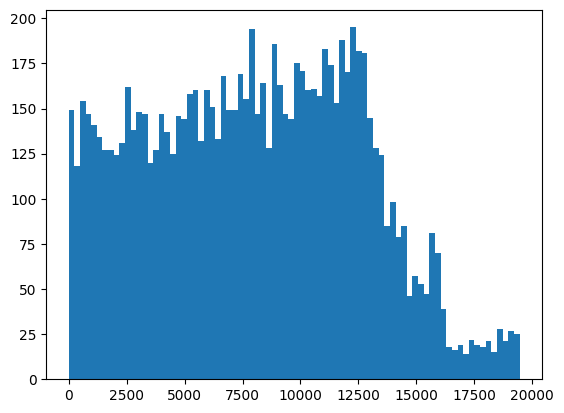

In [42]:
# histogram of all_lineups Ranks
plt.hist(all_lineups['Rank'], bins=80)

In [43]:
len(all_lineups)

9500

In [44]:
# how many in bad_lineups
len(bad_lineups)


863

In [45]:
len(great_lineups)

#great_lineups[2]

72

In [46]:
great_and_bad_lineups_hitters = pd.DataFrame()
great_and_bad_lineups_pitchers = pd.DataFrame()
great_and_bad_lineups = pd.DataFrame()
features = ['position', 'player_drafted_pred', 'payoff_pred', 'opp_mean_pred', 'team_batter_fp_pred', 'player_fp_pred', 'WHIP', 'est_woba', 'est_slg', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame']

# find the difference between the great_lineups and bad_lineups
for i in range(len(great_lineups)):
    # get each lineup individually
    this_lineup_avgs = great_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['great_lineup'] = 1
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    great_and_bad_lineups_hitters = pd.concat([great_and_bad_lineups_hitters, this_lineup_avgs_hitters])
    great_and_bad_lineups_pitchers = pd.concat([great_and_bad_lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'great_lineup_pitcher': 'great_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['great_lineup'])
    great_and_bad_lineups = pd.concat([great_and_bad_lineups, all_lineup_data])

for i in range(len(bad_lineups)):
    # do the same but set great_lineup to 0
    this_lineup_avgs = bad_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['great_lineup'] = 0
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)

    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()

    great_and_bad_lineups_hitters = pd.concat([great_and_bad_lineups_hitters, this_lineup_avgs_hitters])
    great_and_bad_lineups_pitchers = pd.concat([great_and_bad_lineups_pitchers, this_lineup_avgs_pitchers])
    
    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={ 'great_lineup_pitcher': 'great_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['great_lineup'])
    great_and_bad_lineups = pd.concat([great_and_bad_lineups, all_lineup_data])


In [47]:
great_and_bad_lineups.head()

,player_drafted_pred,payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup,player_drafted_pred_pitcher,payoff_pred_pitcher,opp_mean_pred_pitcher,team_batter_fp_pred_pitcher,player_fp_pred_pitcher,WHIP_pitcher,est_woba_pitcher,est_slg_pitcher,hr_friendly_launch_speed_pitcher_pitcher,hr_friendly_launch_angle_pitcher_pitcher,batter_fp_pred_pitcher,pitcher_fp_pred_pitcher,team_batter_fp_pred_pitcher,team_batter_salary_pitcher,batter_drafted_pred_pitcher,pitcher_drafted_pred_pitcher,opp_pitcher_drafted_mean_pitcher,opp_batter_drafted_mean_pitcher,pitcher_payoff_pred_pitcher,Salary_pitcher,AvgPointsPerGame_pitcher
0,10.532719,12.687076,7.391500,72.776795,1047.880935,1.68250,0.309125,0.384125,0.151429,0.093016,7.730376,8.533565,72.776795,36837.5,10.532719,12.418204,10.612014,11.178717,6.131455,4000.0,6.01500,1.0,19.722358,9.104740,5.955291,53.597622,661.523551,1.095,0.2610,0.3410,0.156429,0.072007,4.974049,18.086600,53.597622,33450.0,3.367698,25.371672,19.722358,6.549663,7.500400,8950.0,16.205
0,6.864215,10.393203,11.033855,63.533700,623.114226,1.37875,0.300375,0.376875,0.245665,0.039461,6.641781,10.976593,63.533700,37412.5,6.864215,11.412015,11.512820,6.773454,6.335955,4062.5,5.96125,1.0,21.755894,8.799150,5.862816,52.765344,576.132773,1.000,0.2980,0.3780,0.128068,0.061924,5.194985,20.336538,52.765344,34900.0,3.222612,26.179496,21.755894,5.650230,8.921437,8700.0,15.590
0,8.332483,11.149824,11.929429,65.810709,866.754482,1.36250,0.330500,0.435625,0.158962,0.074008,7.171022,11.544521,65.810709,37562.5,8.332483,13.849970,14.232865,8.476787,7.062216,4262.5,6.60375,1.0,17.326984,9.693512,6.126062,55.134560,659.390948,1.320,0.2755,0.3595,0.164531,0.071865,7.524766,14.251615,55.134560,29150.0,4.927686,21.013099,17.326984,7.732602,7.431030,7900.0,13.190
0,5.744598,10.752861,11.751098,63.762392,717.176408,1.31375,0.300375,0.379250,0.246915,0.039551,6.584609,11.953184,63.762392,38112.5,5.744598,12.216107,11.860344,6.356199,6.209553,4100.0,6.04750,1.0,20.511428,7.876613,5.334898,48.014080,135.889098,1.025,0.2855,0.3245,0.134352,0.060084,5.555536,22.573664,48.014080,30200.0,4.625760,29.288314,20.511428,6.347033,10.047313,8450.0,16.550
0,7.516829,11.866827,8.815381,68.784289,685.797491,1.51875,0.298375,0.352625,0.241201,0.051614,7.160273,9.717158,68.784289,37687.5,7.516829,10.613391,9.094675,8.123121,5.594016,3975.0,6.00250,1.0,19.722358,9.104740,5.955291,53.597622,-78.839344,1.095,0.2610,0.3410,0.156429,0.072007,4.974049,18.086600,53.597622,33450.0,3.367698,25.371672,19.722358,6.549663,7.500400,8950.0,16.205


In [48]:
great_and_bad_lineups_hitters[great_and_bad_lineups_hitters['great_lineup'] == 1]


,player_drafted_pred,payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup
0,10.532719,12.687076,7.391500,72.776795,1047.880935,1.68250,0.309125,0.384125,0.151429,0.093016,7.730376,8.533565,72.776795,36837.5,10.532719,12.418204,10.612014,11.178717,6.131455,4000.0,6.01500,1.0
0,6.864215,10.393203,11.033855,63.533700,623.114226,1.37875,0.300375,0.376875,0.245665,0.039461,6.641781,10.976593,63.533700,37412.5,6.864215,11.412015,11.512820,6.773454,6.335955,4062.5,5.96125,1.0
0,8.332483,11.149824,11.929429,65.810709,866.754482,1.36250,0.330500,0.435625,0.158962,0.074008,7.171022,11.544521,65.810709,37562.5,8.332483,13.849970,14.232865,8.476787,7.062216,4262.5,6.60375,1.0
0,5.744598,10.752861,11.751098,63.762392,717.176408,1.31375,0.300375,0.379250,0.246915,0.039551,6.584609,11.953184,63.762392,38112.5,5.744598,12.216107,11.860344,6.356199,6.209553,4100.0,6.04750,1.0
0,7.516829,11.866827,8.815381,68.784289,685.797491,1.51875,0.298375,0.352625,0.241201,0.051614,7.160273,9.717158,68.784289,37687.5,7.516829,10.613391,9.094675,8.123121,5.594016,3975.0,6.00250,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,6.472885,10.669211,9.251265,67.013508,490.579142,1.45875,0.334875,0.437125,0.186218,0.051345,7.787599,9.108247,67.013508,36725.0,6.472885,10.493266,10.815793,7.270522,4.685447,4312.5,6.88625,1.0
0,6.210680,9.716769,11.421133,64.151082,432.037792,1.34875,0.323750,0.409625,0.178091,0.048172,7.154817,11.378382,64.151082,35800.0,6.210680,14.398848,14.309025,6.470307,5.339260,4000.0,6.44875,1.0
0,4.859114,9.258690,9.876862,71.095882,417.144855,1.38375,0.350875,0.469875,0.168076,0.059056,8.419549,9.216897,71.095882,37575.0,4.859114,7.192942,6.936912,4.831416,2.460267,4587.5,7.78125,1.0
0,9.157962,12.630742,5.621965,77.084612,610.927697,1.53125,0.347125,0.450375,0.189655,0.076182,8.628164,4.486753,77.084612,39725.0,9.157962,1.271397,2.466300,9.031920,2.114045,4400.0,7.00500,1.0


In [49]:
great_and_bad_lineups_hitters[great_and_bad_lineups_hitters['great_lineup'] == 0]


,player_drafted_pred,payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup
0,11.081956,12.816339,6.241550,72.709741,808.529260,1.7525,0.313000,0.382250,0.153232,0.092992,8.277785,6.935757,72.709741,36187.5,11.081956,10.616388,9.620176,11.679616,5.996938,3912.5,6.35000,0.0
0,9.139776,10.373368,10.224207,63.350705,618.717326,1.4975,0.323375,0.397750,0.192628,0.059708,7.449013,8.853163,63.350705,35987.5,9.139776,10.760440,13.219267,8.546543,7.091255,3850.0,6.20750,0.0
0,8.049495,10.586373,13.767104,63.218924,91.042842,1.1875,0.332750,0.425625,0.161988,0.064951,7.273334,13.072344,63.218924,37475.0,8.049495,10.392286,11.660554,7.492291,7.663363,4237.5,7.23875,0.0
0,6.283221,10.839543,15.402563,63.055844,464.877254,1.1075,0.323375,0.410250,0.160522,0.058294,7.172467,15.106644,63.055844,38337.5,6.283221,14.366974,14.887922,6.503677,7.707572,4325.0,7.46250,0.0
0,7.896132,8.362995,12.971737,54.718409,386.741823,1.2100,0.314875,0.404000,0.191720,0.059853,6.298901,12.844366,54.718409,35600.0,7.896132,11.315460,11.539690,7.370816,8.161960,4212.5,6.48375,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,4.874819,7.877972,11.855830,55.750847,107.231340,1.3350,0.333625,0.430250,0.156615,0.059499,7.850360,11.470144,55.750847,30812.5,4.874819,10.007148,10.994953,5.383362,5.644548,4550.0,7.57375,0.0
0,5.806125,8.305239,10.854855,60.505319,1324.083688,1.4200,0.315375,0.394750,0.141458,0.053788,7.338860,11.464353,60.505319,31912.5,5.806125,12.033486,11.467872,5.444992,4.664906,4125.0,6.79000,0.0
0,5.099772,8.501822,9.692959,59.477864,1103.245868,1.5075,0.330875,0.421750,0.165166,0.058574,7.893449,8.068969,59.477864,31012.5,5.099772,7.051285,9.518376,5.855604,4.902173,4225.0,7.06500,0.0
0,5.188367,8.250013,10.814829,62.573313,541.100929,1.4100,0.350250,0.472875,0.193970,0.051987,7.821029,10.474176,62.573313,33412.5,5.188367,7.825951,8.575934,5.347149,4.663078,3887.5,6.39375,0.0


Feature: 0, Score: 0.01814
Feature: 1, Score: 0.04342
Feature: 2, Score: 0.01402
Feature: 3, Score: 0.03141
Feature: 4, Score: 0.00935
Feature: 5, Score: 0.01402
Feature: 6, Score: 0.00361
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.01809
Feature: 9, Score: 0.07428
Feature: 10, Score: 0.11008
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.05398
Feature: 13, Score: 0.01752
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.04313
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.03838
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00285
Feature: 22, Score: 0.00896
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.07839
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.01402
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.06728
Feature: 32, Score: 0.09863
Feature: 33, Score: 0.03128
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

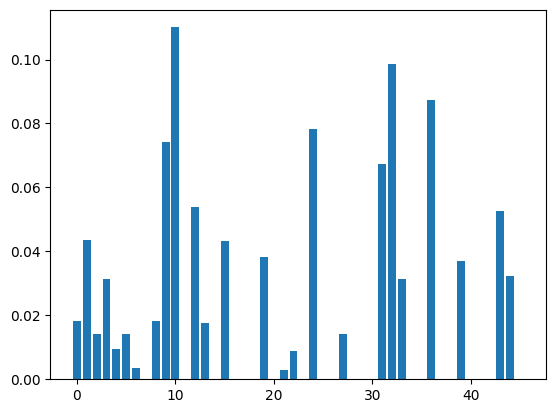

array([[171,   2],
       [  8,   6]], dtype=int64)

In [50]:
# commenting out 'great_lineup' prediction model since it does not seem to be working correctly

# create a model to predict if a lineup is a great lineup based on pregame factors
# # target is great_lineup, features are pregame factors
target = great_and_bad_lineups['great_lineup']
# # feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
feature_names = great_and_bad_lineups.columns[great_and_bad_lineups.columns != 'great_lineup']
features = great_and_bad_lineups[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_great_lineup = LinearRegression()

# # fit the model
# model_is_great_lineup.fit(X_train, y_train)

# # predict the model
# y_pred = model_is_great_lineup.predict(X_test)

# # calculate r2 and rmse
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))

# print('Model R2: ', r2)
# print('Model RMSE: ', rmse)

# # importance of each feature
# importance = model_is_great_lineup.coef_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# do the above for a decision tree classifier model

# establish a model
model_is_great_lineup = DecisionTreeClassifier()

# fit the model
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)
model_is_great_lineup.fit(X_train, y_train)
importance = model_is_great_lineup.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


y_pred = model_is_great_lineup.predict(X_test)
confusion_matrix(y_test, y_pred)


In [51]:


# build a classification model to predict if a lineup is a great lineup
# # target is great_lineup, features are pregame factors
# target = great_and_bad_lineups_pitchers['great_lineup']
# # feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
# feature_names = [ 'opp_mean_pred', 'player_fp_pred', 'WHIP', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'payoff_pred', 'Salary']
# features = great_and_bad_lineups_pitchers[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_great_lineup_pitchers = LogisticRegression()

# # fit the model
# model_is_great_lineup_pitchers.fit(X_train, y_train)

# # predict the model
# y_pred = model_is_great_lineup_pitchers.predict(X_test)

# confusion_matrix(y_test, y_pred)



In [52]:
lineups_hitters = pd.DataFrame()
lineups_pitchers = pd.DataFrame()
cashing_or_not = pd.DataFrame()
features = ['position', 'player_drafted_pred', 'payoff_pred', 'opp_mean_pred', 'team_batter_fp_pred', 'player_fp_pred', 'WHIP', 'est_woba', 'est_slg', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame']

# find the difference between the great_lineups and bad_lineups
for i in range(len(cashing_lineups)):
    # get each lineup individually
    this_lineup_avgs = cashing_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['cashing_lineup'] = 1
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    lineups_hitters = pd.concat([lineups_hitters, this_lineup_avgs_hitters])
    lineups_pitchers = pd.concat([lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'cashing_lineup_pitcher': 'cashing_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['cashing_lineup'])
    cashing_or_not = pd.concat([cashing_or_not, all_lineup_data])

for i in range(len(non_cashing_lineups)):
    # get each lineup individually
    this_lineup_avgs = non_cashing_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['cashing_lineup'] = 0
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    lineups_hitters = pd.concat([lineups_hitters, this_lineup_avgs_hitters])
    lineups_pitchers = pd.concat([lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'cashing_lineup_pitcher': 'cashing_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['cashing_lineup'])
    cashing_or_not = pd.concat([cashing_or_not, all_lineup_data])



Feature: player_drafted_pred, Score: 0.01538
Feature: payoff_pred, Score: 0.04039
Feature: opp_mean_pred, Score: 0.01602
Feature: team_batter_fp_pred, Score: 0.01322
Feature: team_batter_fp_pred, Score: 0.01407
Feature: player_fp_pred, Score: 0.03570
Feature: WHIP, Score: 0.03945
Feature: est_woba, Score: 0.02458
Feature: est_slg, Score: 0.03503
Feature: hr_friendly_launch_speed_pitcher, Score: 0.04786
Feature: hr_friendly_launch_angle_pitcher, Score: 0.06000
Feature: batter_fp_pred, Score: 0.03335
Feature: pitcher_fp_pred, Score: 0.02618
Feature: team_batter_fp_pred, Score: 0.00757
Feature: team_batter_fp_pred, Score: 0.01074
Feature: team_batter_salary, Score: 0.03962
Feature: batter_drafted_pred, Score: 0.02079
Feature: pitcher_drafted_pred, Score: 0.02014
Feature: opp_pitcher_drafted_mean, Score: 0.03327
Feature: opp_batter_drafted_mean, Score: 0.04309
Feature: pitcher_payoff_pred, Score: 0.06515
Feature: Salary, Score: 0.02224
Feature: AvgPointsPerGame, Score: 0.03079
Feature: pla

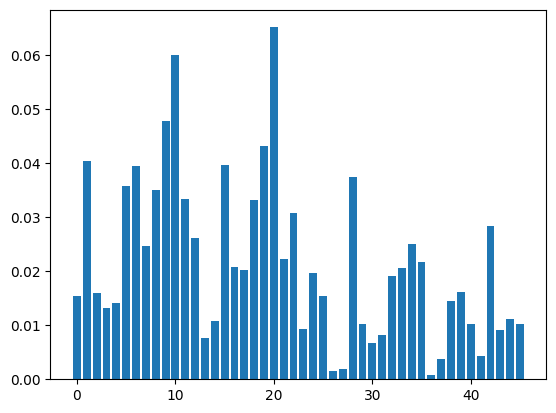

array([[1284,  223],
       [ 217,  176]], dtype=int64)

In [53]:
# classification model to predict if a lineup is a cashing lineup
# target is cashing_lineup, features are pregame factors
target = cashing_or_not['cashing_lineup']
# feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
feature_names = cashing_or_not.columns[cashing_or_not.columns != 'cashing_lineup']
features = cashing_or_not[feature_names]
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# establish a model
model_is_cashing_lineup = DecisionTreeClassifier()

# fit the model
model_is_cashing_lineup.fit(X_train, y_train)
importance = model_is_cashing_lineup.feature_importances_
names = model_is_cashing_lineup.feature_names_in_

# summarize feature importance
for i,v in enumerate(importance):
    # print feature name
    print('Feature: %s, Score: %.5f' % (names[i],v))
    #print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# predict the model
y_pred = model_is_cashing_lineup.predict(X_test)
confusion_matrix(y_test, y_pred)

In [54]:
# change to True to run the following code
if False:
    best_lineup = pd.DataFrame()
    best_lineup_rank = 100000

    for i in range(150):
        lineup = build_one_lineup(all_variables)
        # get only variables for players with names in lineup_players
        lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

        # add a dummy column to lineup_vars to groupby
        lineup_vars['Rank'] = 'dummy'

        lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
        lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

        lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
        lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

        # rename pitcher columns by suffixing with '_pitcher'
        lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
        lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

        # merge hitters and pitchers on Rank and Date
        combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

        # drop Rank
        combined_vars = combined_vars.drop(columns='Rank')
        
        # get rank predictions
        lineup_rank_prediction = model.predict(combined_vars)
        lineup_rank_prediction = lineup_rank_prediction[0]

        if lineup_rank_prediction < best_lineup_rank:
            best_lineup = lineup

    best_lineup

In [55]:
### using the model to predict the rank of lineups built by build_one_lineup to filter best possible entries and backtest potential earnings had those been entered ###
# scrapped 5/26 as data was not correct and 6/2 as it was giving errors
lineups_to_build = 100
def backtest_with_models():
    files = get_files()

    # read model from 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
    model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))

    all_sum_fpts = []
    all_lineup_ranks = []
    all_lineup_payoffs = []
    #all_lineup_utilities = []
    all_lineup_rank_preds = []
    keepers = []
    # create a table for earnings per day
    earnings = pd.DataFrame()
    all_lineups = pd.DataFrame()

    for file in files:
        # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
        if 'MLBContestStandings' in file:
            date = file[-12:-4]
            m = str(date[0:2])
            d = str(date[2:4])
            y = str(date[4:8])
            # break if date is 06/02
            #if int(d) > 2 and int(m) == 6:
            if not (m == '06' and d == '02'):
                todays_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])
                print('Getting data for ', m, d, y)
                contest_data = get_contest_standings(y, m, d)
                contest_player_results = get_contest_results(contest_data)
                leaderboard = get_leaderboard(contest_data)
                # skip if leaderboard has > 20000 rows or < 13000 rows
                if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                    
                    # change 'Player' to 'Name' in contest_player_results
                    contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

                    # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
                    contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                    
                    #someday will implement this rather than the below scripting, but for now keeping things as before
                    #build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
                    all_variables = get_all_variables(y, m, d, optional='', df=df)

                    payoff_total = 0
                    # max_fpts = 0
                    # max_lineup_rank = 100000
                    
                    # define an empty array to store lineups that rank > 14000
                    
                    # build lineups until lineups_to_build is reached
                    pbar = tqdm(desc="while loop", total=lineups_to_build)
                    i= 0
                    while i < lineups_to_build:
                        lineup = build_one_lineup(all_variables, all_variables)                        
                        # get only variables for players with names in lineup_players
                        lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

                        # add a dummy column to lineup_vars to groupby
                        lineup_vars['Rank'] = 'dummy'

                        lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
                        lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

                        lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
                        lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

                        # rename pitcher columns by suffixing with '_pitcher'
                        lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
                        lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

                        # merge hitters and pitchers on Rank and Date
                        combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

                        # drop Rank
                        rank_model_vars = combined_vars[['batting_order', 'avg_batter_fp', 'avg_batting_order', 'est_woba',
                            'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq',
                            'hr_friendly_launch_angle_freq', 'Pitching+', 'WHIP',
                            'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher',
                            'batting_order_change', 'batter_fp_pred', 'pitcher_fp_pred',
                            'team_batter_fp_pred', 'teams_in_game_pk', 'is_of',
                            'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred',
                            'payoff_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean',
                            'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame',
                            'player_fp_pred', 'player_drafted_pred', 'payoff', 'opp_mean_pred',
                            'batting_order_pitcher', 'avg_batter_fp_pitcher',
                            'avg_batting_order_pitcher', 'est_woba_pitcher', 'est_slg_pitcher',
                            'est_ba_pitcher', 'hr_friendly_launch_speed_freq_pitcher',
                            'hr_friendly_launch_angle_freq_pitcher', 'Pitching+_pitcher',
                            'WHIP_pitcher', 'hr_friendly_launch_speed_pitcher_pitcher',
                            'hr_friendly_launch_angle_pitcher_pitcher',
                            'batting_order_change_pitcher', 'batter_fp_pred_pitcher',
                            'pitcher_fp_pred_pitcher', 'team_batter_fp_pred_pitcher',
                            'teams_in_game_pk_pitcher', 'is_of_pitcher',
                            'team_batter_salary_pitcher', 'batter_drafted_pred_pitcher',
                            'pitcher_drafted_pred_pitcher', 'payoff_pred_pitcher',
                            'opp_pitcher_drafted_mean_pitcher', 'opp_batter_drafted_mean_pitcher',
                            'pitcher_payoff_pred_pitcher', 'Salary_pitcher',
                            'AvgPointsPerGame_pitcher', 'player_fp_pred_pitcher',
                            'player_drafted_pred_pitcher', 'payoff_pitcher',
                            'opp_mean_pred_pitcher']]
                        
                        # if combined_vars is empty, skip to next iteration
                        if rank_model_vars.empty:
                            continue

                        rank_model_vars = update_rank_model(rank_model_vars)
                        
                        great_lineup_vars = combined_vars[model_is_cashing_lineup.feature_names_in_]
                        # get rank predictions
                        lineup_rank_prediction = model.predict(rank_model_vars)[0]
                        great_lineup_prediction = model_is_great_lineup.predict(great_lineup_vars)[0]
                        cashing_lineup_prediction = model_is_cashing_lineup.predict(great_lineup_vars)[0]

                        if great_lineup_prediction == 0 and cashing_lineup_prediction == 0:
                            continue
                        else:
                            # get actual fpts for lineup based on contest_player_results
                            lineup['fpts'] = lineup['Name'].map(contest_player_results)
                            lineup_fpts = lineup['fpts'].sum()

                            # get rank of lineup in leaderboard
                            lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)
                            keepers.append(lineup)

                            # get payoff based on rank
                            this_payoff = get_payoff(lineup_rank)

                            # add current results to arrays
                            all_sum_fpts.append(lineup['player_fp_pred'].sum())
                            all_lineup_ranks.append(lineup_rank)
                            all_lineup_payoffs.append(this_payoff)
                            #all_lineup_utilities.append(lineup['Utility'].sum())
                            all_lineup_rank_preds.append(lineup_rank_prediction)

                            # add to todays_lineups
                            todays_lineups = pd.concat([todays_lineups, pd.DataFrame({'Date': [date], 'Rank': [lineup_rank], 'Rank_pred': [lineup_rank_prediction], 'Payoff': [this_payoff]})])
                            i = len(todays_lineups)

                        pbar.update(1)
                    pbar.close()
                    # get the payoff_total for all generated lineups
                    payoff_total_all = todays_lineups['Payoff'].sum()
                    
                    # add to all_lineups
                    all_lineups = pd.concat([all_lineups, todays_lineups])

                    # add to earnings table
                    timestamp = datetime.datetime.now().time()
                    earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'GeneratedAt': [timestamp], 'Filtered Lineups Earnings': [payoff_total_all]})])

    return all_lineups, earnings, keepers

lineups, earnings, keepers = backtest_with_models()
earnings

Getting data for  05 23 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05232024.csv
Getting data for  05 24 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05242024.csv
Getting data for  05 25 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05252024.csv
Getting data for  05 27 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05272024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


while loop: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Getting data for  05 28 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05282024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Getting data for  05 29 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05292024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


while loop: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Getting data for  05 30 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05302024.csv
Getting data for  05 31 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05312024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


while loop: 100%|██████████| 100/100 [00:32<00:00,  3.09it/s]


Getting data for  06 03 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06032024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Getting data for  06 04 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06042024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Getting data for  06 05 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06052024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Getting data for  06 06 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06062024.csv
Getting data for  06 07 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06072024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


Getting data for  06 08 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06082024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


while loop: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Getting data for  06 09 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06092024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


Getting data for  06 10 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06102024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


while loop: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


Getting data for  06 11 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06112024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


Getting data for  06 12 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06122024.csv
Getting data for  06 13 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06132024.csv
Getting data for  06 14 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06142024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06142024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06142024.csv
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


while loop: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


Getting data for  06 15 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06152024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06152024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06152024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Getting data for  06 16 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06162024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06162024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06162024.csv
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


while loop: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Getting data for  06 17 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06172024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


while loop: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Getting data for  06 18 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06182024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06182024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06182024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Getting data for  06 19 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06192024.csv
Getting data for  06 20 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06202024.csv
Getting data for  06 21 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06212024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06212024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06212024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


while loop: 100%|██████████| 100/100 [03:34<00:00,  2.14s/it]


Getting data for  06 22 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06222024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06222024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06222024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


,Date,GeneratedAt,Filtered Lineups Earnings
0,05272024,01:15:32.103359,-525
0,05282024,01:17:07.321088,-520
0,05292024,01:18:15.892513,-625
0,05312024,01:19:34.702573,150
0,06032024,01:21:18.448393,475
0,06042024,01:23:04.540634,-720
0,06052024,01:24:19.690836,-615
0,06072024,01:26:35.576635,-165
0,06082024,01:27:59.522884,-870
0,06092024,01:29:28.009422,-1320


In [67]:
# get pct earnings for each day
pct_earnings = earnings.copy()
pct_earnings['Filtered Lineups Earnings'] = pct_earnings['Filtered Lineups Earnings'].astype(float)/(lineups_to_build*15)*100
print("Sum filtered lineups earnings: ", pct_earnings['Filtered Lineups Earnings'].sum())

Sum filtered lineups earnings:  3384.333333333334


In [65]:
len(keepers)/len(lineups) * 100 # percentage of lineups kept

9500

In [57]:
# get all variables - refreshes default data before building

# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]

# optional = ''

# pregame_data = get_pregame_info(df, year, month, day)
# all_players_plus_data = get_todays_data(year, month, day, optional=optional, pregame_data=pregame_data, df=df)

# all_variables = get_all_variables(year, month, day, optional='', df=df)

In [58]:
# save models to disk
pickle.dump(model_is_great_lineup, open('C:\\Users\\jorda\\Downloads\\model_is_great_lineup.sav', 'wb'))
pickle.dump(model_is_cashing_lineup, open('C:\\Users\\jorda\\Downloads\\model_is_cashing_lineup.sav', 'wb'))

In [90]:
# display floats to 1 decimal
pd.options.display.float_format = '{:.3f}'.format
all_variables[(all_variables['team'] == 'CIN')].sort_values(by='player_fp_pred', ascending=False)


,Name,batting_order,Roster Position_x,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred,value
18,Graham Ashcraft,9.000,OF,5.809,6.170,0.282,0.339,0.212,0.163,0.038,96,1.460,0.203,0.068,-2.830,6.517,12.442,65.988,6,1,32600,8.954,26.045,15.880,21.177,12.114,7.889,jack suwinski,graham ashcraft,SP,Graham Ashcraft (34787377),34787377,P,7800,PIT@CIN 06/26/2024 01:10PM ET,CIN,10.500,graham ashcraft,9.676,21.177,7.889,PIT,7.332,1.241


Mass Multi Entry Builder

In [133]:

# build a csv of dk lineups using get_best_lineup

# Number of lineups at the end
lineups_to_build = 532
# Number of lineups to build, of which we select the best ranked lineups_to_build
# iterations = 200
# banned players by name
bans = ['TOR', 'BOS', 'Tyler Holton', 'Spencer Turnbull', 'Jake Fraley']
# Max percent of lineups that should include a single player
# max_own_goal = 0.7
# sets the standard deviation for the normal distribution used to select players
stdev = 9

# year, month day, optional and df are all defined above
optional = ''
# def build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df):
# get all variables - refreshes default data before building

all_variables = get_all_variables(year, month, day, optional, df=df)
all_variables['ID'] = all_variables['ID'].astype(str)
# bans = ['William Contreras', 'Connor Wong', 'Jose Trevino', 'TB', 'MIN']

# all_variables = all_variables[~all_variables['Name'].isin(bans)]
# all_variables = all_variables[~all_variables['team'].isin(bans)]

temp_col_names = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', 'Rank_pred', 'key']
column_names = ['P', 'P', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
lineups = pd.DataFrame(columns=temp_col_names)
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
model_is_cashing_lineup = pickle.load(open('C:\\Users\\jorda\\Downloads\\model_is_cashing_lineup.sav', 'rb'))
model_is_great_lineup = pickle.load(open('C:\\Users\\jorda\\Downloads\\model_is_great_lineup.sav', 'rb'))

# # create a dictionary to store number of times each id is in a lineup
# id_counts = dict.fromkeys(all_variables['ID'], 0)
# # get max number of times a player can be in a lineup
# max_id_count = int(lineups_to_build * max_own_goal)

pbar = tqdm(total=lineups_to_build, desc="while loop")
i = 0
counter = 0
while i < lineups_to_build:
    # add progress bar to loop with tqdm
    counter += 1
    lineup_vars = build_one_lineup(all_variables, all_variables, bans=bans, stdev=stdev)
    
    # add a dummy column to lineup_vars to groupby
    lineup_vars['Rank'] = 'dummy'

    lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
    lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

    lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
    lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

    # rename pitcher columns by suffixing with '_pitcher'
    lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
    lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

    # merge hitters and pitchers on Rank and Date
    combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

    # drop Rank
    combined_vars = combined_vars.drop(columns='Rank')

    combined_vars = update_rank_model(combined_vars)
    rank_model_vars = combined_vars[['batting_order', 'avg_batter_fp', 'avg_batting_order',
    'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq',
    'hr_friendly_launch_angle_freq', 'Pitching+', 'WHIP',
    'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher',
    'batting_order_change', 'batter_fp_pred', 'pitcher_fp_pred',
    'team_batter_fp_pred', 'teams_in_game_pk', 'is_of',
    'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred',
    'payoff_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean',
    'pitcher_payoff_pred',  'Salary', 'AvgPointsPerGame',
    'player_fp_pred', 'player_drafted_pred', 'payoff', 'opp_mean_pred',
    'batting_order_pitcher', 'avg_batter_fp_pitcher',
    'avg_batting_order_pitcher', 'est_woba_pitcher', 'est_slg_pitcher',
    'est_ba_pitcher', 'hr_friendly_launch_speed_freq_pitcher',
    'hr_friendly_launch_angle_freq_pitcher', 'Pitching+_pitcher',
    'WHIP_pitcher', 'hr_friendly_launch_speed_pitcher_pitcher',
    'hr_friendly_launch_angle_pitcher_pitcher',
    'batting_order_change_pitcher', 'batter_fp_pred_pitcher',
    'pitcher_fp_pred_pitcher', 'team_batter_fp_pred_pitcher',
    'teams_in_game_pk_pitcher', 'is_of_pitcher',
    'team_batter_salary_pitcher', 'batter_drafted_pred_pitcher',
    'pitcher_drafted_pred_pitcher', 'payoff_pred_pitcher',
    'opp_pitcher_drafted_mean_pitcher', 'opp_batter_drafted_mean_pitcher',
    'pitcher_payoff_pred_pitcher', 'Salary_pitcher',
    'AvgPointsPerGame_pitcher', 'player_fp_pred_pitcher',
    'player_drafted_pred_pitcher', 'payoff_pitcher',
    'opp_mean_pred_pitcher', 'total_fp_pred', 'drafted_product',
    'total_net_sqrt_pred']]

    great_lineup_vars = combined_vars[model_is_cashing_lineup.feature_names_in_]
    # get rank predictions
    lineup_rank_prediction = model.predict(rank_model_vars)[0]
    great_lineup_prediction = model_is_great_lineup.predict(great_lineup_vars)[0]
    cashing_lineup_prediction = model_is_cashing_lineup.predict(great_lineup_vars)[0]

    if great_lineup_prediction == 0 and cashing_lineup_prediction == 0:
        continue
    else:
    # alphabetize IDs, concatenate as single string, add to lineup as key
        alphabetized_ids = lineup_vars['ID'].astype(str).sort_values().tolist()
        alphabetized_ids = ''.join(alphabetized_ids)

        # add lineup prediction to lineup ids
        ids = lineup_vars['ID'].tolist()

        ids.append(lineup_rank_prediction)
        ids.append(alphabetized_ids)
        
        lineups = pd.concat([lineups, pd.DataFrame([ids], columns=temp_col_names)])
        # drop duplicates
        lineups = lineups.drop_duplicates(subset='key') 
        i = len(lineups)
        pbar.update(1)
pbar.close()

# # get the best 'lineups_to_build' lineups based on rank prediction
# lineups = lineups.sort_values(by='Rank_pred').head(lineups_to_build)

# get lineup ids
lineups = lineups.drop(columns=['Rank_pred', 'key'])

# rename columns
lineups.columns = column_names
# return lineups

# lineups = build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
# save lineups to csv
lineups.to_csv('C:\\Users\\jorda\\Downloads\\lineups.csv', index=False)

C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06262024.csv
Year:  2024 Month:  06 Day:  26 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06262024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


while loop: 538it [01:27,  6.14it/s]                         


In [60]:
lineups

,P,P,C,1B,2B,3B,SS,OF,OF,OF
0,34787377,34786961,34787005,34787038,34786979,34786990,34787010,34786976,34787065,34787059
0,34786963,34786962,34787005,34787006,34787061,34786999,34787010,34787009,34786976,34787058
0,34786963,34786961,34787005,34787038,34786979,34786990,34787102,34787017,34786976,34787074
0,34786963,34786962,34787075,34787078,34787003,34786990,34786989,34787051,34787011,34786975
0,34786961,34786966,34787005,34787004,34786979,34787035,34787010,34787058,34786976,34787016
...,...,...,...,...,...,...,...,...,...,...
0,34786963,34786961,34787005,34787078,34787003,34787077,34786988,34786976,34786995,34787051
0,34786963,34786961,34787005,34787038,34786979,34787099,34786988,34786976,34787074,34787011
0,34786963,34786962,34787005,34787038,34787099,34786990,34787010,34786975,34786976,34787074
0,34787377,34786962,34787005,34787006,34786979,34786999,34787098,34786976,34787058,34786997


In [61]:

print('Great lineup prediction: ', great_lineup_prediction, '\nCashing lineup prediction: ', cashing_lineup_prediction, '\nLineups for export: ', len(lineups), '\nLineups built: ', counter)


Great lineup prediction:  0.0 
Cashing lineup prediction:  1.0 
Lineups for export:  118 
Lineups built:  228


In [62]:
for i in range(len(lineups)):
    c_id = lineups.iloc[i][2]
    lineup_catcher = all_variables[all_variables['ID'] == c_id]
    # c_name = lineup_catcher['Name'].values[0]
    # print(i, c_id, c_name)
    print(lineup_catcher['Name'])


55    Yainer Diaz
Name: Name, dtype: object
55    Yainer Diaz
Name: Name, dtype: object
55    Yainer Diaz
Name: Name, dtype: object
56    Yasmani Grandal
Name: Name, dtype: object
55    Yainer Diaz
Name: Name, dtype: object
20    Hunter Goodman
Name: Name, dtype: object
20    Hunter Goodman
Name: Name, dtype: object
20    Hunter Goodman
Name: Name, dtype: object
20    Hunter Goodman
Name: Name, dtype: object
55    Yainer Diaz
Name: Name, dtype: object
55    Yainer Diaz
Name: Name, dtype: object
53    William Contreras
Name: Name, dtype: object
55    Yainer Diaz
Name: Name, dtype: object
56    Yasmani Grandal
Name: Name, dtype: object
55    Yainer Diaz
Name: Name, dtype: object
53    William Contreras
Name: Name, dtype: object
55    Yainer Diaz
Name: Name, dtype: object
55    Yainer Diaz
Name: Name, dtype: object
11    Carson Kelly
Name: Name, dtype: object
53    William Contreras
Name: Name, dtype: object
55    Yainer Diaz
Name: Name, dtype: object
55    Yainer Diaz
Name: Name, dtype: 

In [134]:
def write_to_entries():
    # import from DKEntriesMLB.csv
    # use columns  0 - 16
    entries = pd.read_csv('C:\\Users\\jorda\\Downloads\\DKEntriesMLB.csv', sep=",", header=0, names=range(14), usecols=range(14))
    # change column names to original
    entries = entries.drop(columns=range(4, 14))
   
    # replace columns 4-13 with IDs from 'C:\\Users\\jorda\\Downloads\\lineups.csv'
    new_lineups = pd.read_csv('C:\\Users\\jorda\\Downloads\\lineups.csv')
    # make new_lineups all strings
    new_lineups = new_lineups.astype(str)
    entries = entries.astype(str)
    entries = pd.concat([entries, new_lineups], axis=1)
    # remove NaNs
    entries.columns = ['Entry ID', 'Contest Name', 'Contest ID', 'Entry Fee', 'P', 'P', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
    entries = entries.dropna()
     # remove decimals from first column if there is a decimal
    entries.replace('\.0', '', regex=True, inplace=True)

    # remove scientific notation
    pd.options.display.float_format = '{:.0f}'.format
    # write to csv, do not include index
    entries.to_csv('C:\\Users\\jorda\\Downloads\\DKEntriesMLB.csv', index=False)
    return entries
entries = write_to_entries()

In [135]:
def check_ownership(lineups, top_own = 20):
    num_built = lineups.shape[0]
    # check number of times each player is in lineups and sort by most to least
    ownership = lineups.stack().value_counts().reset_index()
    ownership = ownership.rename(columns={'index': 'ID', 0: 'count'})
    ownership = ownership.sort_values(by='count', ascending=False)
    ownership = pd.merge(ownership, all_variables[['ID', 'Name', 'team', 'position']], on='ID')
    # calculate percentage of lineups each player is in, rounded to 2 decimal places
    ownership['percentage'] = (ownership['count'] / num_built) * 100
    print(ownership.head(top_own))

check_ownership(lineups, top_own=40)


          ID  count                Name team position  percentage
0   34786963    312        Brady Singer   KC        P          59
1   34786961    266      Nathan Eovaldi  TEX        P          50
2   34787377    176     Graham Ashcraft  CIN        P          33
3   34786977    155           Alec Bohm  PHI       3B          29
4   34786971    151        Bryce Harper  PHI       1B          28
5   34786972    134     Elly De La Cruz  CIN       SS          25
6   34786974    131         Trea Turner  PHI       SS          25
7   34786966    127  Spencer Arrighetti  HOU        P          24
8   34786999    121        Alex Bregman  HOU       3B          23
9   34786973    120      Kyle Schwarber  PHI       OF          23
10  34786979    120         Jose Altuve  HOU       2B          23
11  34786987    120        Bryson Stott  PHI       2B          23
12  34787030    115    Tyler Stephenson  CIN        C          22
13  34786976    113      Yordan Alvarez  HOU       OF          21
14  347870